In [7]:
import numpy as np
import fitsio
from astropy.table import Table, join
import os, sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import pandas as pd
import corner
import mpl_scatter_density

# Make the norm object to define the image stretch
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(vmin=0., vmax=1000, stretch=LogStretch())

import sys
sys.path.insert(0, '/global/homes/s/severett/repos/balutils/')
from balutils import stacked_catalogs as sc

import seaborn as sb
plt.style.use('seaborn')
sb.set_context("notebook", font_scale=1.5)

In [8]:
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sb.axisgrid.FacetGrid) or \
            isinstance(self.sg, sb.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sb.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])
        
        # added by me
#         self.sg.ax_marg_x.remove()

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())


## Make Pure Star Sample

In [10]:
run = 'run2'
ver = '1.4'

match_file = '/project/projectdirs/des/severett/Balrog/{}/stacked_catalogs/stars/{}/sof/balrog_matched_catalog_sof_{}_stars_v{}.fits'.format(run, ver, run, ver)
det_file = '/project/projectdirs/des/severett/Balrog/{}/stacked_catalogs/stars/{}/sof/balrog_detection_catalog_sof_{}_stars_v{}_avg_added_match_flags.fits'.format(run, ver, run, ver)

match_cols = ['bal_id', 'meas_cm_mag_deredden', 'meas_gapflux', 'meas_cm_fracdev',
              'true_g_Corr', 'true_gr_corr', 'true_ri_Corr', 'true_iz_Corr', 'meas_cm_s2n_r', 'meas_cm_T', 'meas_cm_flux_s2n',
              'meas_psf_mag', 'ext_mag', 'meas_cm_flux_cov']
det_cols = ['bal_id', 'meas_FLAGS_GOLD_SOF_ONLY', 'flags_foreground', 'flags_footprint', 'flags_badregions', 'meas_EXTENDED_CLASS_SOF','match_flag_1.5_asec']

print('Loading matched file...')
match = Table(fitsio.read(match_file, columns=match_cols))
print('Loading det file...')
det = Table(fitsio.read(det_file, columns=det_cols))
print('joining...')
stars = join(match, det, keys='bal_id', join_type='inner')
assert len(match) == len(stars)

cuts = np.where(
    (stars['meas_FLAGS_GOLD_SOF_ONLY'] < 2) &
    (stars['flags_foreground'] == 0 ) &
    (stars['flags_footprint'] == 1) &
    (stars['flags_badregions'] < 2) &
    (stars['meas_EXTENDED_CLASS_SOF'] >= 0) &
    (stars['meas_EXTENDED_CLASS_SOF'] <= 1) &
    (stars['match_flag_1.5_asec'] < 2)
)

print('Making cuts...')
stars = stars[cuts]

# Make mag cols for ease of use
stars['true_mag_g'] = stars['true_g_Corr']
stars['true_mag_r'] = stars['true_g_Corr'] - stars['true_gr_Corr']
stars['true_mag_i'] = stars['true_g_Corr'] - stars['true_gr_Corr'] - stars['true_ri_Corr']
stars['true_mag_z'] = stars['true_g_Corr'] - stars['true_gr_Corr'] - stars['true_ri_Corr'] - stars['true_iz_Corr']

if 'meas_psf_mag' in stars.colnames:
    stars['meas_psf_mag_deredden'] = stars['meas_psf_mag']- stars['ext_mag']

Loading matched file...
Loading det file...
joining...
Making cuts...


In [11]:
stars_file = './cats/balrog_sof_gold_phot_scatter_stars.fits' 
print('Writing catalog...')
stars.write(stars_file, overwrite=True)

Writing catalog...


## Make DF Star Sample

In [13]:
run = 'y3-merged'
ver = '1.2'

match_file = '/project/projectdirs/des/severett/Balrog/{}/stacked_catalogs/{}/sof/balrog_matched_catalog_sof_{}_v{}.fits'.format(run, ver, run, ver)
det_file = '/project/projectdirs/des/severett/Balrog/{}/stacked_catalogs/{}/sof/balrog_detection_catalog_sof_{}_v{}.fits'.format(run, ver, run, ver)

match_cols = ['bal_id', 'meas_cm_mag_deredden',  'true_bdf_mag_deredden', 'true_gap_flux_fwhm4asec', 'meas_gapflux',
              'meas_psf_mag', 'meas_cm_fracdev', 'true_bdf_fracdev', 'meas_cm_flux_cov', 'true_bdf_flux_deredden']
det_cols = ['bal_id', 'true_id', 'meas_FLAGS_GOLD_SOF_ONLY', 'flags_foreground', 'flags_footprint', 'flags_badregions', 'match_flag_1.5_asec',
            'meas_EXTENDED_CLASS_SOF']
# sof = sc.BalrogMatchedCatalog(match_file, det_file, match_cols=match_cols, match_type='sof_only', vb=True)

print('Loading matched file...')
match = Table(fitsio.read(match_file, columns=match_cols))
print('Loading det file...')
det = Table(fitsio.read(det_file, columns=det_cols))
print('Joining...')
sof = join(match, det, keys='bal_id', join_type='inner')
assert len(match) == len(sof)

# Match to Ian's DF classifier
df_file = 'cats/ugriz-mof02-JHK-extcorr_27May20_kNN_class.fits'
df = Table.read(df_file)
df.rename_column('id', 'true_id')

print('Joining with df classifier...')
sof = join(sof, df, keys='true_id', join_type='left')

cuts = np.where(
    (sof['meas_FLAGS_GOLD_SOF_ONLY'] < 2) &
    (sof['flags_foreground'] == 0 ) &
    (sof['flags_footprint'] == 1) &
    (sof['flags_badregions'] < 2) &
    (sof['NearestNeighbors_class'] == 2) &
    (sof['match_flag_1.5_asec'] < 2)
)

print('Making cuts...')
sof = sof[cuts]

Loading matched file...
Loading det file...
Joining...
Joining with df classifier...
Making cuts...


(array([     0.,      0.,      0.,      0.,      0., 626675.,      0.,
             0.,      0.,      0.]),
 array([1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5]),
 <a list of 10 Patch objects>)

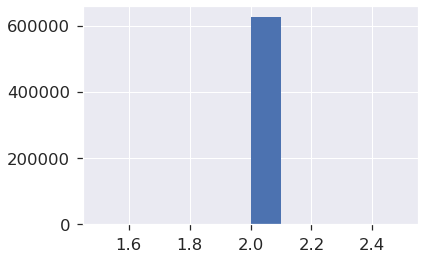

In [5]:
plt.hist(sof['NearestNeighbors_class'])

In [6]:
sof

<Table length=626675>
  true_bdf_fracdev  true_bdf_mag_deredden [4] ... NearestNeighbors_class
      float64                float32          ...        float64        
------------------- ------------------------- ... ----------------------
0.49944168521427523    25.071697 .. 22.790302 ...                    2.0
0.49944168521427523    25.071697 .. 22.790302 ...                    2.0
0.49944168521427523    25.071697 .. 22.790302 ...                    2.0
0.49944168521427523    25.071697 .. 22.790302 ...                    2.0
0.49944168521427523    25.071697 .. 22.790302 ...                    2.0
0.49944168521427523    25.071697 .. 22.790302 ...                    2.0
0.49944168521427523    25.071697 .. 22.790302 ...                    2.0
0.49944168521427523    25.071697 .. 22.790302 ...                    2.0
0.49944168521427523    25.071697 .. 22.790302 ...                    2.0
0.49944168521427523    25.071697 .. 22.790302 ...                    2.0
                ...                       ... ...                    ...
0.49911772894356665    26.296495 .. 22.443222 ...                    2.0
0.49911772894356665    26.296495 .. 22.443222 ...                    2.0
0.49911772894356665    26.296495 .. 22.443222 ...                    2.0
0.49911772894356665    26.296495 .. 22.443222 ...                    2.0
0.49911772894356665    26.296495 .. 22.443222 ...                    2.0
0.49911772894356665    26.296495 .. 22.443222 ...                    2.0
0.49911772894356665    26.296495 .. 22.443222 ...                    2.0
0.49911772894356665    26.296495 .. 22.443222 ...                    2.0
0.49911772894356665    26.296495 .. 22.443222 ...                    2.0
0.48548883791830416    26.174816 .. 24.327408 ...                    2.0

In [14]:
df_stars_file = './cats/balrog_sof_gold_phot_scatter_stars_df.fits' 
print('Writing catalog...')
sof.write(df_stars_file, overwrite=True)

Writing catalog...


/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(array([1.95074214e-07, 2.28001570e-08, 0.00000000e+00, 0.00000000e+00,
        4.83336134e-09, 1.28896971e-07, 8.57878940e-08, 1.84100290e-07,
        4.60443685e-09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.02405972e-07]),
 array([6.91667161e+08, 6.92744163e+08, 6.93821165e+08, 6.94898167e+08,
        6.95975169e+08, 6.97052172e+08, 6.98129174e+08, 6.99206176e+08,
        7.00283178e+08, 7.01360180e+08, 7.02437182e+08, 7.03514184e+08,
        7.04591186e+08, 7.05668188e+08, 7.06745190e+08, 7.07822192e+08,
        7.08899195e+08, 7.09976197e+08, 7.11053199e+08, 7.12130201e+08,
        7.13207203e+08]),
 <a list of 20 Patch objects>)

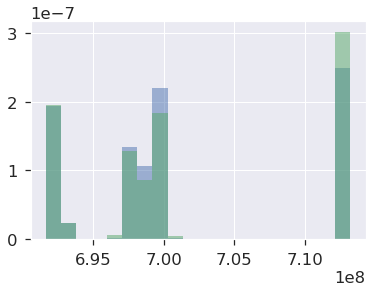

In [8]:
bins = 20
plt.hist(sof['true_id'], label='balrog', bins=bins, normed=True, alpha=0.5)
plt.hist(df['true_id'], label='df', bins=bins, normed=True, alpha=0.5)

# Load Existing Catalogs

In [9]:
stars_file = './cats/balrog_sof_gold_phot_scatter_stars.fits' 
stars = Table.read(stars_file)

In [10]:
df_stars_file = './cats/balrog_sof_gold_phot_scatter_stars_df.fits' 
sof = Table.read(df_stars_file)

## Plots!

## Color Color Plot

[0.39346934 0.86466472]
0
1246435
1224082
plotting true...
plotting meas...
1
1246422
1244469
plotting true...
plotting meas...


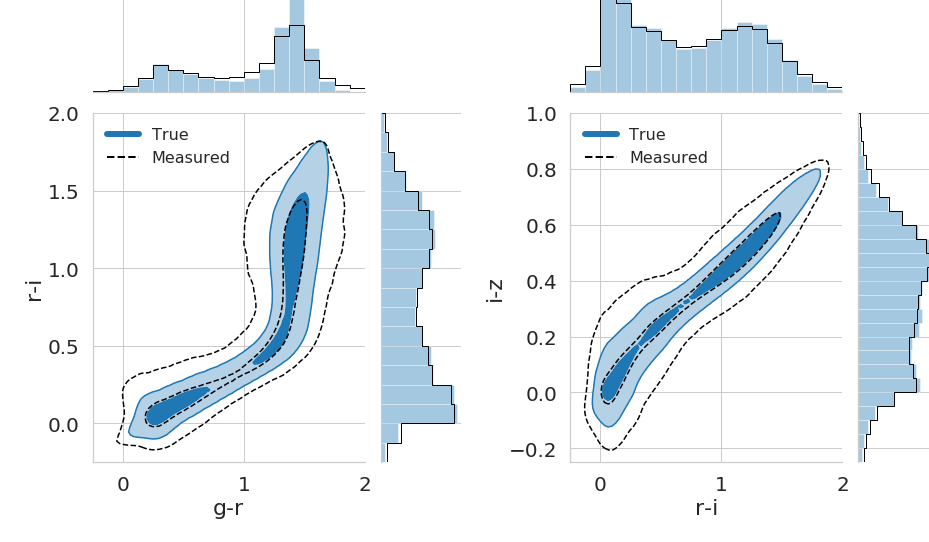

In [12]:
sb.set_style('whitegrid')

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

bindx = dict(zip('griz', [0,1,2,3]))

bands = 'griz'
bindx = dict(zip('griz', range(4)))

dx = [0.125, 0.125]
dy = [0.125, 0.05]
xlim = ([-.25, 2], [-.25, 2.0]) # For 2 sig
ylim = ([-.25, 2.0], [-.25, 1.0]) # For 2 sig
# xlim = ([-.75, 3.5], [-.75, 2.5]) # For 3 sig
# ylim = ([-.75, 2.5], [-.75, 1.25]) # For 3 sig
r = ((xlim[0], ylim[0]), (xlim[1], ylim[1]))

bins = 75
n_levels = 4

dl = 1
levels = 1.0 - np.exp(-0.5 * np.arange(1.0, 2.0+dl, dl) ** 2)
# levels = 1.0 - np.exp(-0.5 * np.arange(1.0, +dl, dl) ** 2)
# levels = 1.0 - np.exp(-0.5 *np.array([1, 2, 2.5]) ** 2)
print(levels)

# N = 1000
frac = 1. # Fraction of data to plot

true_c = 'tab:blue'
meas_c = 'k'

joint = 'corner'

meas_mag_colname = 'meas_cm_mag_deredden'
# meas_mag_colname = 'meas_psf_mag'

vb = True

# fig, axes = plt.subplots(2, 2)

g = []

k = 0
colors = ['g-r', 'r-i', 'i-z']
for k in range(2):
    if vb is True:
        print(f'{k}')
        
    c1b1, c1b2 = colors[k][0], colors[k][2]
    c2b1, c2b2 = colors[k+1][0], colors[k+1][2]
        
    true_x = stars[f'true_mag_{c1b1}'] - stars[f'true_mag_{c1b2}'] # g-r
    true_y = stars[f'true_mag_{c2b1}'] - stars[f'true_mag_{c2b2}'] # r-i
    meas_x = stars[meas_mag_colname][:, k] - stars[meas_mag_colname][:, k+1] # g-r
    meas_y = stars[meas_mag_colname][:, k+1] - stars[meas_mag_colname][:, k+2] # r-i

    true_cuts = np.where(
        (true_x > xlim[k][0]-1) &
        (true_x < xlim[k][1]+1) &
        (true_y > ylim[k][0]-1) &
        (true_y < ylim[k][1]+1)  )
    
    meas_cuts = np.where(
        (meas_x > xlim[k][0]-1) &
        (meas_x < xlim[k][1]+1) &
        (meas_y > ylim[k][0]-1) &
        (meas_y < ylim[k][1]+1)  )

    Ntcuts = len(true_cuts[0])
    Nmcuts = len(meas_cuts[0])
    true_sample = np.random.choice(np.arange(Ntcuts), int(Ntcuts*frac), replace=False)
    meas_sample = np.random.choice(np.arange(Nmcuts), int(Nmcuts*frac), replace=False)

#     g.append(sb.JointGrid(true_x[true_cuts][::N], true_y[true_cuts][::N], ratio=3))
    g.append(sb.JointGrid(true_x[true_cuts][true_sample], true_y[true_cuts][true_sample], ratio=3))

    if vb is True:
        print(len(true_x[true_cuts][true_sample]))
        print(len(meas_x[meas_cuts][meas_sample]))
        print('plotting true...')
    if joint == 'kde':
        p = g[k].plot_joint(sb.kdeplot, color='tab:blue', shade=True, label='True',
                        shade_lowest=False, n_levels=n_levels)
    elif joint == 'corner':
        p = g[k].plot_joint(corner.hist2d, range=r[k], bins=bins, scale_hist=1,
#                plot_density=True, fill_contours=False, no_fill_contours=True
               plot_density=False, fill_contours=True,
               plot_datapoints=False, data_kwargs={'alpha':0.01}, levels=levels,
               color=true_c, smooth=True, lw=3, label='True')
    
    if vb is True:
        print('plotting meas...')
    if joint == 'kde':
        sb.kdeplot(meas_x[meas_cuts][meas_sample], meas_y[meas_cuts][meas_sample],
                   color='k', linestyles='--', shade=False, label='Meas', alpha=0.7, n_levels=n_levels)
    elif joint == 'corner':
        corner.hist2d(meas_x[meas_cuts][meas_sample], meas_y[meas_cuts][meas_sample],
                      range=r[k], bins=bins, scale_hist=1, 
                      contour_kwargs={'linestyles':'dashed'},
                      plot_datapoints=False, data_kwargs={'alpha':0.01}, plot_density=False, 
                      no_fill_contours=True, levels=levels,
                      color=meas_c, smooth=True, lw=3, label='Meas')
        
    # Add legend
    plot_lines = []
    p1, = plt.plot([1], [1], lw=6, color='tab:blue')
    p2, = plt.plot([1], [1], lw=2, color='k', ls='--')
    plot_lines.append([p1, p2])
    l2 = plt.legend(plot_lines[0], ['True', 'Measured'], loc='upper left')
        
#     plt.gcf().legend(['True', 'Meas'])
        
#     g[k].ax_joint.legend(loc='lower right') 
        
    plt.xlabel(f'{colors[k]}')
    plt.ylabel(f'{colors[k+1]}')
    plt.xlim(xlim[k])
    plt.ylim(ylim[k]) 
    
    xbins = np.arange(xlim[k][0], xlim[k][1]+dx[k], dx[k])
    ybins = np.arange(ylim[k][0], ylim[k][1]+dy[k], dy[k])
    
#     g[k].plot_marginals(sb.distplot, color='tab:blue', kde=False)
    sb.distplot(true_x[true_cuts][true_sample], color='tab:blue', bins=xbins, kde=False, ax=g[k].ax_marg_x, axlabel=False)
    sb.distplot(true_y[true_cuts][true_sample], color='tab:blue', bins=ybins, kde=False, ax=g[k].ax_marg_y, axlabel=False, vertical=True)
    g[k].ax_marg_x.hist(meas_x[meas_cuts][meas_sample], histtype='step', color='k', bins=xbins)
    g[k].ax_marg_y.hist(meas_y[meas_cuts][meas_sample], histtype='step', color='k', bins=ybins, orientation='horizontal')
    
fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(1, 3)

mg0 = SeabornFig2Grid(g[0], fig, gs[0])
mg1 = SeabornFig2Grid(g[1], fig, gs[1])

# fig.suptitle('Balrog y3-merged GOLD Sample')
gs.tight_layout(fig)

fig.set_size_inches(24, 5)

fig.savefig('./figs/delta-star-color-color.png', bbox_inches='tight')
fig.savefig('./figs/delta-star-color-color.pdf', bbox_inches='tight')

In [19]:
fig.savefig('./figs/delta-star-color-color.png')
fig.savefig('./figs/delta-star-color-color.pdf')

In [13]:
pwd

'/global/u2/s/severett/balrog-paper-plots'

0
1246
1224
plotting true...
plotting meas...
1
1246
1244
plotting true...
plotting meas...


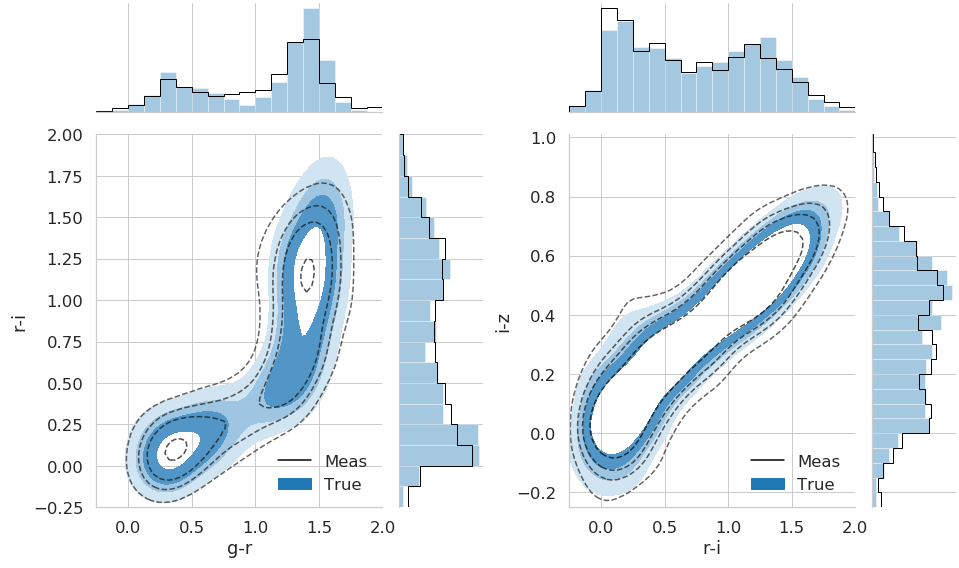

In [40]:
sb.set_style('whitegrid')

bindx = dict(zip('griz', [0,1,2,3]))

bands = 'griz'
bindx = dict(zip('griz', range(4)))

dx = [0.125, 0.125]
dy = [0.125, 0.05]
xlim = ([-.25, 2], [-.25, 2.0])
ylim = ([-.25, 2.], [-.25, 1.01])
r = ((xlim[0], ylim[0]), (xlim[1], ylim[1]))

bins = 75
# n_levels = 4

# levels = np.ones(3) - np.array([0.989, 0.865, 0.393]) # 2d sigma values
# levels = np.array([0.393, 0.865, 1.]) # 2d sigma values
levels = np.array([0.2, 0.4, 0.6, 1.0])


# N = 1000
frac = .001 # Fraction of data to plot

true_c = 'tab:blue'
meas_c = 'k'

joint = 'kde'

vb = True

# fig, axes = plt.subplots(2, 2)

g = []

k = 0
colors = ['g-r', 'r-i', 'i-z']
for k in range(2):
    if vb is True:
        print(f'{k}')
        
    c1b1, c1b2 = colors[k][0], colors[k][2]
    c2b1, c2b2 = colors[k+1][0], colors[k+1][2]
        
    true_x = stars[f'true_mag_{c1b1}'] - stars[f'true_mag_{c1b2}'] # g-r
    true_y = stars[f'true_mag_{c2b1}'] - stars[f'true_mag_{c2b2}'] # r-i
    meas_x = stars['meas_cm_mag_deredden'][:, k] - stars['meas_cm_mag_deredden'][:, k+1] # g-r
    meas_y = stars['meas_cm_mag_deredden'][:, k+1] - stars['meas_cm_mag_deredden'][:, k+2] # r-i

    true_cuts = np.where(
        (true_x > xlim[k][0]-1) &
        (true_x < xlim[k][1]+1) &
        (true_y > ylim[k][0]-1) &
        (true_y < ylim[k][1]+1)  )
    
    meas_cuts = np.where(
        (meas_x > xlim[k][0]-1) &
        (meas_x < xlim[k][1]+1) &
        (meas_y > ylim[k][0]-1) &
        (meas_y < ylim[k][1]+1)  )

    Ntcuts = len(true_cuts[0])
    Nmcuts = len(meas_cuts[0])
    true_sample = np.random.choice(np.arange(Ntcuts), int(Ntcuts*frac), replace=False)
    meas_sample = np.random.choice(np.arange(Nmcuts), int(Nmcuts*frac), replace=False)

#     g.append(sb.JointGrid(true_x[true_cuts][::N], true_y[true_cuts][::N], ratio=3))
    g.append(sb.JointGrid(true_x[true_cuts][true_sample], true_y[true_cuts][true_sample], ratio=3))

    if vb is True:
        print(len(true_x[true_cuts][true_sample]))
        print(len(meas_x[meas_cuts][meas_sample]))
        print('plotting true...')
    if joint == 'kde':
        p = g[k].plot_joint(sb.kdeplot, color='tab:blue', shade=True, label='True',
                        shade_lowest=True, levels=levels)#n_levels=n_levels)
    elif joint == 'corner':
        p = g[k].plot_joint(corner.hist2d, range=r[k], bins=bins, scale_hist=1,
               plot_datapoints=False, plot_density=True, no_fill_contours=True,
               color=true_c, smooth=True, lw=3, levels=levels, label='True')

    
    if vb is True:
        print('plotting meas...')
    if joint == 'kde':
        sb.kdeplot(meas_x[meas_cuts][meas_sample], meas_y[meas_cuts][meas_sample],
                   color='k', linestyles='--', shade=False, label='Meas', levels=levels, alpha=0.7)
    elif joint == 'corner':
        corner.hist2d(meas_x[meas_cuts][meas_sample], meas_y[meas_cuts][meas_sample],
                      range=r[k], bins=bins, scale_hist=1, linestyles='--',
                      plot_datapoints=False, plot_density=False, no_fill_contours=True,
                      color=meas_c, smooth=True, lw=3, levels=levels, label='Meas')
        
    g[k].ax_joint.legend(loc='lower right') 
        
    plt.xlabel(f'{colors[k]}')
    plt.ylabel(f'{colors[k+1]}')
    plt.xlim(xlim[k])
    plt.ylim(ylim[k]) 
    
    xbins = np.arange(xlim[k][0], xlim[k][1]+dx[k], dx[k])
    ybins = np.arange(ylim[k][0], ylim[k][1]+dy[k], dy[k])
    
#     g[k].plot_marginals(sb.distplot, color='tab:blue', kde=False)
    sb.distplot(true_x[true_cuts][true_sample], color='tab:blue', bins=xbins, kde=False, ax=g[k].ax_marg_x, axlabel=False)
    sb.distplot(true_y[true_cuts][true_sample], color='tab:blue', bins=ybins, kde=False, ax=g[k].ax_marg_y, axlabel=False, vertical=True)
    g[k].ax_marg_x.hist(meas_x[meas_cuts][meas_sample], histtype='step', color='k', bins=xbins)
    g[k].ax_marg_y.hist(meas_y[meas_cuts][meas_sample], histtype='step', color='k', bins=ybins, orientation='horizontal')
    
fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(1, 3)

mg0 = SeabornFig2Grid(g[0], fig, gs[0])
mg1 = SeabornFig2Grid(g[1], fig, gs[1])

# fig.suptitle('Balrog y3-merged GOLD Sample')
gs.tight_layout(fig)

fig.set_size_inches(24, 5)

In [ ]:
corner.quantile()

## Magnitude Scatter

In [3]:
def calc_bin_stats(true, diff, bins):
    '''
    Calculate mean offset mean, median, nd scatter in truth bins, given bin edges
    '''
    
    mean = -1*np.ones(len(bins)-1)
    med = -1*np.ones(len(bins)-1)
    scatter = -1*np.ones(len(bins)-1)
    
    bin_mean = np.mean([bins[:-1], bins[1:]], axis=0)
    
    k = 0
    for b1, b2 in zip(bins, bins[1:]):
        sample = np.where((true > b1) & (true <= b2))
        mean[k] = np.mean(diff[sample])
        med[k] = np.median(diff[sample])
        scatter[k] = np.std(diff[sample])
        k += 1
        
    return mean, med, scatter, bin_mean

def calc_meas_mag_err(true_mag, true_flux, flux_var, bins):
    mag_err = -1*np.ones(len(bins)-1)
    
    bin_mean = np.mean([bins[:-1], bins[1:]], axis=0)
    
    k = 0
    for b1, b2 in zip(bins, bins[1:]):
        sample = np.where((true_mag > b1) & (true_mag <= b2))
        
        sig_f = np.sqrt(flux_var[sample])
        sig_m = (2.5 / np.log(10)) * (sig_f / true_flux[sample])
        var_m = np.power(sig_m, 2)
        
        mag_err[k] = np.sqrt(np.mean(var_m))
        k += 1
        
    return mag_err, bin_mean

def mag2flux(mag, zp=30.):
    return np.power(10, -0.4*(mag-zp))

g 0


/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3254: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


r 1
i 2
z 3
saving fig...


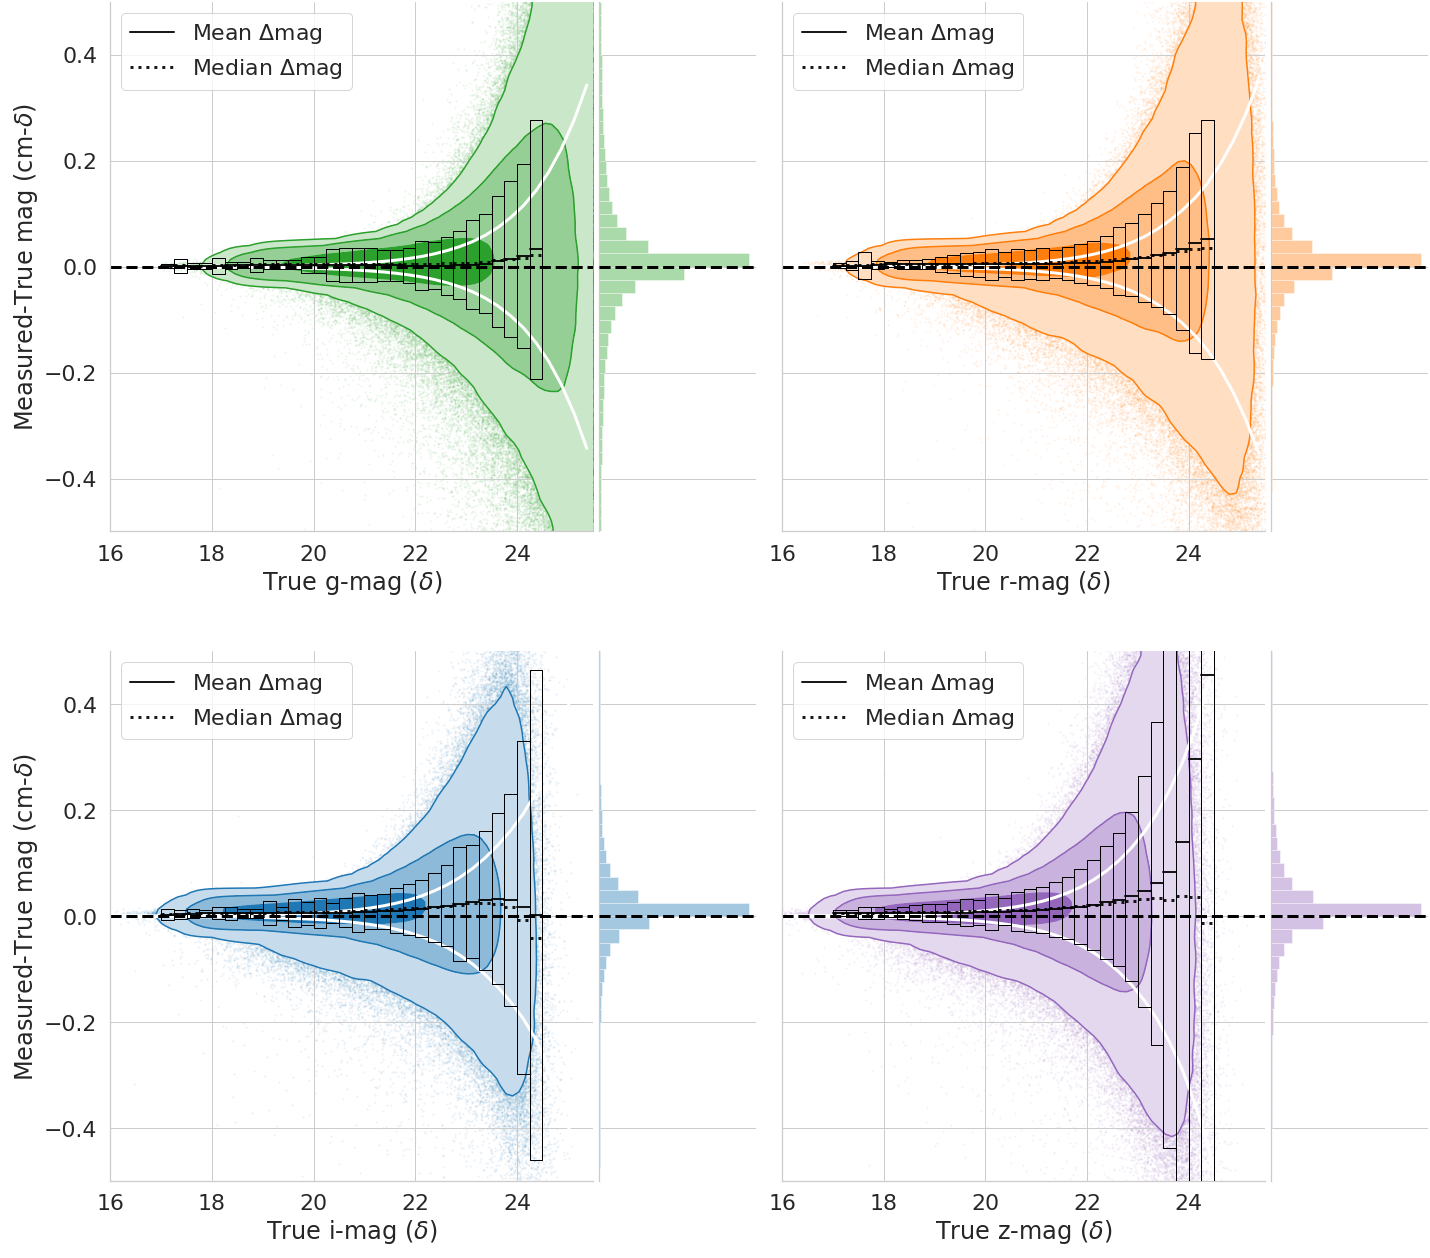

In [23]:
sb.set_style("whitegrid")# {"axes.facecolor": "0.9"})

# used in arxiv submission
# SMALL_SIZE = 18
# MEDIUM_SIZE = 24
# BIGGER_SIZE = 26

# used in ApJS resubmission
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

bands = 'griz'
bindx = dict(zip('griz', range(4)))

xlim = [16, 25.5]
ylim = [-.5, .5]

r = (xlim, ylim)
bins = 75

dy = 0.025
ybins = np.arange(ylim[0], ylim[1]+dy, dy)

N = 1
c = ['tab:green', 'tab:orange', 'tab:blue', 'tab:purple']
# c = ['limegreen', 'salmon', 'skyblue', 'orchid']

dl = 1.0
levels = 1.0 - np.exp(-0.5 * np.arange(dl, 3.+dl, dl) ** 2)

vb = True

# fig, axes = plt.subplots(2, 2)

g = {}

meas_mag_colname = 'meas_cm_mag'
# meas_mag_colname = 'meas_psf_mag'

mag_suffix = '_deredden' # For corrected mags
# mag_suffix = '' # For uncorrected mags

stats_t = Table()

paper_t = Table()

j = 0
for b, bi in bindx.items():
    j += 1
    if vb is True:
        print(b, bi)
        
    x = stars[f'true_mag_{b}']
    y = stars[f'{meas_mag_colname}{mag_suffix}'][:, bi] - x

    cuts = np.where(
        (x > xlim[0]-1) &
        (x < xlim[1]+1) &
        (y > ylim[0]-1) &
        (y < ylim[1]+1)  )

# ax1 = fig.add_subplot(1, 1, 1)
    g[b] = sb.JointGrid(x[cuts][::N], y[cuts][::N], ratio=3)    
#     plt.subplot(2, 2, k)  
#     corner.hist2d(x[cuts][::N], y[cuts][::N], range=r, bins=bins, color=c[bi])
#     g[b].plot_joint(plt.hexbin, gridsize=50, color=c[bi])
    g[b].plot_joint(corner.hist2d, range=r, bins=75, scale_hist=1,
                   plot_datapoints=False, plot_density=False, no_fill_contours=False,
                   fill_contours=True,
                   color=c[bi], smooth=True, lw=3, alpha=0.01, levels=levels,
                   contour_kwargs={'zorder':1}) # added for ApJS resubmission
    plt.plot(x[cuts][::N], y[cuts][::N], "o", ms=2, zorder=-1, rasterized=True, alpha=0.1, c=c[bi], mec='None')
#     plt.hist2d(x[cuts][::10*N], y[cuts][::10*N], range=r, bins=75, scale_hist=1,
#                    plot_datapoints=True, plot_density=False, no_fill_contours=True,
#                    plot_contours=False, color=c[bi])
    plt.axhline(0, ls='--', c='k', lw=3)
#     g = sb.JointGrid(x[cuts][::N], y[cuts][::N], ax=plt.gca())
#     g.plot_joint(plt.hexbin, gridsize=50)

    # Compare to meas estimates
    dx = 0.25
    xbins2 = np.arange(xlim[0], xlim[1]+dx, dx)
    true_mag = x[cuts][::N]
    true_flux = mag2flux(true_mag)
    flux_var = stars['meas_cm_flux_cov'][:, bi, bi][cuts][::N]
    
    mag_err, bin_mean2 = calc_meas_mag_err(true_mag, true_flux, flux_var, xbins2)
    
#     plt.fill_between(bin_mean2, -mag_err, mag_err, color='gray', alpha=0.5, label='Mean reported error')
    
    meas_lw = 3
    meas_c = 'white'
    meas_ls = 'solid'
    plt.plot(bin_mean2, mag_err, lw=meas_lw, c=meas_c, ls=meas_ls, zorder=1)
    plt.plot(bin_mean2, -mag_err, lw=meas_lw, c=meas_c, ls=meas_ls, zorder=1)

    # Get rolling bias & scatter
#     dx = 0.5
    xbins = np.arange(xlim[0]+1, xlim[1]+dx-1, dx)
    mean, med, scatter, bin_mean = calc_bin_stats(x, y, xbins)
    
    k = 0
    for b1, b2 in zip(xbins, xbins[1:]):
        if k == 0:
            l1 = r'Mean $\Delta$mag'
            l2 = r'Median $\Delta$mag'
        else:
            l1 = None
            l2 = None
        plt.plot([b1, b2], [mean[k], mean[k]], c='k', label=l1, lw=2, alpha=0.9, zorder=5)
        plt.plot([b1, b2], [med[k], med[k]], c='k', ls=':', label=l2, lw=3, alpha=0.9, zorder=5)
#         plt.fill_between([b1, b2], mean[k]+scatter[k], mean[k]-scatter[k], facecolor='lightgrey', edgecolor='dimgrey', alpha=0.2)
        plt.fill_between([b1, b2], mean[k]+scatter[k], mean[k]-scatter[k], facecolor='None', edgecolor='k', zorder=5)
        k += 1
#     plt.step(xbins[:-1], mean, c='r', label=r'mean $\Delta m$')
#     plt.step(xbins[:-1], med, c='g', label=r'median $\Delta$ m$')
    
    plt.legend(loc='upper left', fancybox=True, frameon=True)
    
    # Save to table
    stats_t[f'mean_{b}'] = mean
    stats_t[f'med_{b}'] = med
    stats_t[f'std_{b}'] = scatter
    stats_t[f'bin_mean_{b}'] = bin_mean
    
    if 'Mag' not in paper_t.colnames:
        paper_t[f'Mag'] = bin_mean - dx / 2.
    paper_t[f'avg_{b}'] = mean
    paper_t[f'med_{b}'] = med
    paper_t[f'std_{b}'] = scatter

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel(fr'True {b}-mag ($\delta$)')
    
    if (j%2) == 1:
        plt.ylabel(f'Measured-True mag (cm-$\delta$)')
    else:
        plt.gca().yaxis.set_ticklabels([])
        plt.gca().yaxis.label.set_visible(False)
#     plt.ylabel(f'Measured-True {b}-mag (cm-$\delta$)')
    
    g[b].plot_marginals(sb.distplot, color=c[bi], bins=ybins, kde=False)
    g[b].ax_marg_x._visible = False
#     g[b].ax_marg_y.hist(y[cuts][::N], color=c[bi], bins=ybins, orientation='horizontal')
    g[b].ax_marg_y.axhline(0, ls='--', c='k', lw=3, zorder=3)

#     g[b].ax_marg_x.set_axis_off()
    
s = (20, 20)
fig = plt.figure(figsize=s)
w, h = 1, 0
gs = gridspec.GridSpec(2, 2)

mg0 = SeabornFig2Grid(g['g'], fig, gs[0])
mg1 = SeabornFig2Grid(g['r'], fig, gs[1])
mg2 = SeabornFig2Grid(g['i'], fig, gs[2])
mg3 = SeabornFig2Grid(g['z'], fig, gs[3])

# mg0.sg.ax_marg_x.remove()

# fig.suptitle('Balrog y3-stars GOLD Sample')
# fig.set_size_inches(s, s)
plt.tight_layout(pad=0.5)


# Save table
if 'deredden' in mag_suffix:
    l = 'deredden'
else:
    l = 'uncorrected'
stats_t.write(f'./tables/star-scatter-mag-stats-{meas_mag_colname}{l}.fits', overwrite=True)
paper_t.write(f'./tables/star-mag-response-{l}.csv', overwrite=True)

print('saving fig...')
outfile = './figs/balrog-stars-mag-response-revised.pdf'
fig.savefig(outfile, bbox_inches='tight', rasterized=True)

# h = []

# for b in 'griz':
#     h.append(plt.hist(stars[f'true_mag_{b}'], bins=np.arange(16, 26, 0.5), histtype='step', lw=2, label=b, density=True))
    
# plt.legend()
# plt.xlabel('True mag')
# plt.show()

# for i in range(4):
#     b = 'griz'[i]
#     print('griz'[i] + ' ' + str(h[i][1][np.argmax(h[i][0])]))

## Color

g 0
r 1
i 2


/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3254: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(r

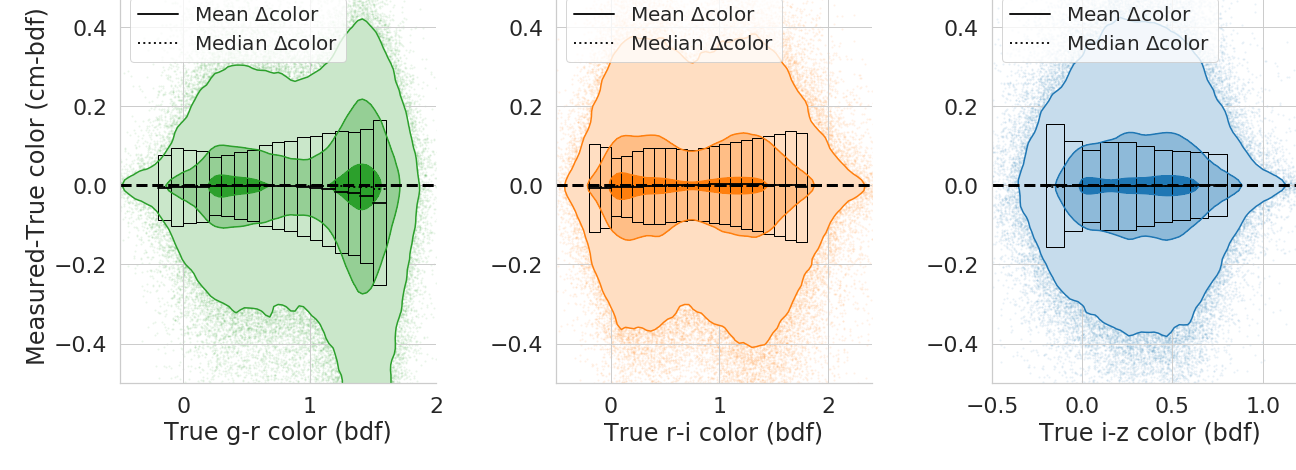

In [7]:
sb.set_style("whitegrid")# {"axes.facecolor": "0.9"})

SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

bands = 'griz'
bindx = dict(zip('griz', range(4)))

xlim = ([-0.5, 2], [-0.5, 2.4], [-0.5, 1.25])
ylim = [-0.5, 0.5]
bins = 75

cbin_range = ([-0.1, 1.7], [-0.1, 1.8], [-0.1, 0.8])
# cbin_dx = (0.1, 0.1, 0.05)
cbin_dx = (0.1, 0.1, 0.1)
# cbin_dx = (0.05, 0.05, 0.05)

dy = 0.025
ybins = np.arange(ylim[0], ylim[1]+dy, dy)

s = 20
N = 1
c = ['tab:green', 'tab:orange', 'tab:blue', 'tab:purple']

dl = 1.0
levels = 1.0 - np.exp(-0.5 * np.arange(dl, 3.+dl, dl) ** 2)

vb = True

g = {}

mag_suffix = '_deredden' # For corrected mags
# mag_suffix = '' # For uncorrected mags

stats_t = Table()

paper_t = Table()

k = 0
for b, bi in bindx.items():
    k += 1
    if k >= 4:
        break
    if vb is True:
        print(b, bi)
        
    b1, b2 = 'griz'[bi], 'griz'[bi+1]
        
    x = stars[f'true_mag_{b1}'] - stars[f'true_mag_{b2}'] 
    y = (stars['meas_cm_mag_deredden'][:, bi] - stars['meas_cm_mag_deredden'][:, bi+1]) - x

#     cuts = np.where(
#         (x > xlim[k-1][0]-1) &
#         (x < xlim[k-1][1]+1) &
#         (y > ylim[0]-1) &
#         (y < ylim[1]+1)  )

    cuts = np.where(
        (stars['meas_cm_flux_s2n'][:,bi] > 5) &
        (stars['meas_cm_flux_s2n'][:,bi+1] > 5)
    )

    g[b] = sb.JointGrid(x[cuts][::N], y[cuts][::N], ratio=3)    

    r = (xlim[k-1], ylim)
    g[b].plot_joint(corner.hist2d, range=r, bins=75, scale_hist=1,
                   plot_datapoints=False, plot_density=False, no_fill_contours=False,
                   fill_contours=True,
                   color=c[bi], smooth=True, lw=3, alpha=0.01, levels=levels)
    
    plt.plot(x[cuts][::N], y[cuts][::N], "o", ms=2, zorder=-1, rasterized=True, alpha=0.1, c=c[bi], mec='None')

    plt.axhline(0, ls='--', c='k', lw=3)

    # due to non-detections, colors splan unrealistic range
    thresh = 4
    c_cuts = np.where(
        (stars['meas_cm_flux_s2n'][:,bi] > 3) &
        (stars['meas_cm_flux_s2n'][:,bi+1] > 3) #&
#         (stars['meas_cm_flux_s2n'][:,2] > 5) &
#         (stars['meas_cm_flux_s2n'][:,3] > 5) #&
#         (x > -thresh) &
#         (x < thresh) &
#         (y > -thresh) &
#         (y < thresh)
    )
    dcx = cbin_dx
#     xbins = np.arange(-1, 2.5+dcx[k-1], dcx[k-1])
    xbins = np.arange(-0.2, 1.8+dcx[k-1], dcx[k-1])
    mean, med, scatter, bin_mean = calc_bin_stats(x[c_cuts], y[c_cuts], xbins)
    
    j = 0
    leg = False
    for b1, b2 in zip(xbins, xbins[1:]):
        if (b2 < cbin_range[k-1][0]) or (b2 > cbin_range[k-1][1]):
            j += 1
            continue
        if leg is False:
            l1 = r'Mean $\Delta$color'
            l2 = r'Median $\Delta$color'
            leg = True
        else:
            l1 = None
            l2 = None
        
        plt.plot([b1, b2], [mean[j], mean[j]], c='k', label=l1, lw=2, alpha=0.9)
        plt.plot([b1, b2], [med[j], med[j]], c='k', ls=':', label=l2, lw=2, alpha=0.9)
        
        # TEMP!!
#         mean = np.mean(y[c_cuts][(x[c_cuts] > b1) & (x[c_cuts] <= b2)])
#         plt.plot([b1, b2], [mean, mean], c='k', label=l1, lw=2, alpha=0.9)
#         med = np.median(y[c_cuts][(x[c_cuts] > b1) & (x[c_cuts] <= b2)])
#         plt.plot([b1, b2], [med, med], c='k', ls=':', label=l2, lw=2, alpha=0.9)
#         scatter = np.std(y[c_cuts][(x[c_cuts] > b1) & (x[c_cuts] <= b2)])
        
#         plt.fill_between([b1, b2], mean[j]+scatter[k], mean[k]-scatter[k], facecolor='lightgrey', edgecolor='dimgrey', alpha=0.2)
        plt.fill_between([b1, b2], mean[j]+scatter[j], mean[j]-scatter[j], facecolor='None', edgecolor='k')
#         plt.fill_between([b1, b2], mean+scatter, mean-scatter, facecolor='None', edgecolor='k')

        j += 1
#     plt.step(xbins[:-1], mean, c='r', label=r'mean $\Delta m$')
#     plt.step(xbins[:-1], med, c='g', label=r'median $\Delta$ m$')
    plt.legend(loc='upper left', fancybox=True, frameon=True)
    
#     Save to table
#     stats_t[f'mean_{b}'] = mean
#     stats_t[f'med_{b}'] = med
#     stats_t[f'std_{b}'] = scatter
#     stats_t[f'bin_mean_{b}'] = bin_mean

    b1, b2 = b, 'griz'[bi+1]

    if 'Color' not in paper_t.colnames:
        paper_t[f'Color'] = bin_mean - dcx[k-1] / 2.
    paper_t[f'avg_{b1}-{b2}'] = mean
    paper_t[f'med_{b1}-{b2}'] = med
    paper_t[f'std_{b1}-{b2}'] = scatter

    plt.xlim(xlim[k-1])
    plt.ylim(ylim)
    plt.xlabel(f'True {b1}-{b2} color (bdf)')
    
    if k == 1:
        plt.ylabel(f'Measured-True color (cm-bdf)')
    
#     g[b].plot_marginals(sb.distplot, color=c[bi], bins=ybins, kde=False)
    g[b].ax_marg_x._visible = False
    g[b].ax_marg_y._visible = False
    if k != 1:
        plt.gca().set(ylabel=None)
#     g[b].ax_marg_y.hist(y[cuts][::N], color=c[bi], bins=ybins, orientation='horizontal')
#     g[b].ax_marg_y.axhline(0, ls='-/-', c='k', lw=3)

#     g[b].ax_marg_x.set_axis_off()
    
fig = plt.figure(figsize=(20, 9))

gs = gridspec.GridSpec(1, 3)

mg0 = SeabornFig2Grid(g['g'], fig, gs[0])
mg1 = SeabornFig2Grid(g['r'], fig, gs[1])
mg2 = SeabornFig2Grid(g['i'], fig, gs[2])

# mg0.sg.ax_marg_x.remove()

plt.tight_layout()
# fig.suptitle('Balrog y3-merged GOLD Sample')
# fig.set_size_inches(12, 4)

# Save table
if 'deredden' in mag_suffix:
    l = 'deredden'
else:
    l = 'uncorrected'
# stats_t.write(f'./tables/star-scatter-color-stats-{l}.fits', overwrite=True)
# paper_t.write(f'./tables/star-color-response-{l}.csv', overwrite=True)

# fig.savefig('./figs/balrog-stars-color-response.pdf', bbox_inches='tight', rasterize=True)

g 0
r 1
i 2


/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3254: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/global/homes/s/severett/.conda/envs/balrog-plots/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(r

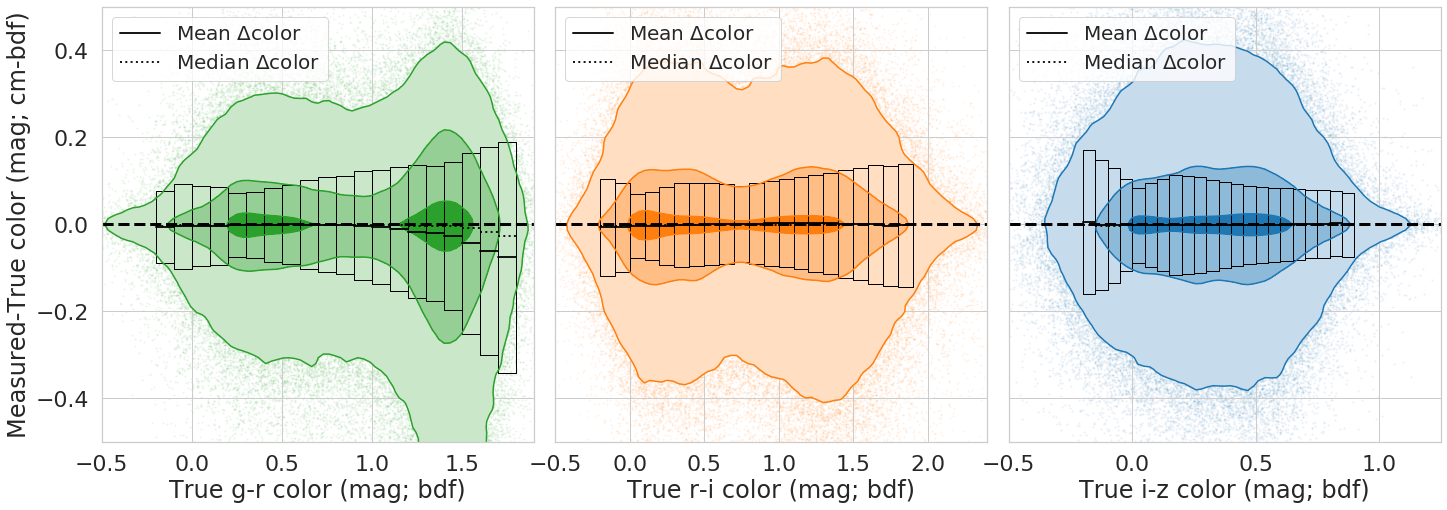

In [11]:
sb.set_style("whitegrid")# {"axes.facecolor": "0.9"})

SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

bands = 'griz'
bindx = dict(zip('griz', range(4)))

xlim = ([-0.5, 1.9], [-0.5, 2.4], [-0.5, 1.25])
ylim = [-0.5, 0.5]
bins = 75

cbin_range = ([-0.1, 1.9], [-0.1, 1.95], [-0.2, 0.9])
cbin_dx = (0.1, 0.1, 0.05)
# cbin_dx = (0.1, 0.1, 0.1)
# cbin_dx = (0.05, 0.05, 0.05)

dy = 0.025
ybins = np.arange(ylim[0], ylim[1]+dy, dy)

s = 20
N = 1
c = ['tab:green', 'tab:orange', 'tab:blue', 'tab:purple']

dl = 1.0
levels = 1.0 - np.exp(-0.5 * np.arange(dl, 3.+dl, dl) ** 2)

vb = True

g = {}

mag_suffix = '_deredden' # For corrected mags
# mag_suffix = '' # For uncorrected mags

stats_t = Table()

paper_t = Table()

fig, axes = plt.subplots(1,3, sharey=True)

k = 0
for b, bi in bindx.items():
    k += 1
    if k >= 4:
        break
    if vb is True:
        print(b, bi)
        
    b1, b2 = 'griz'[bi], 'griz'[bi+1]
        
    x = stars[f'true_mag_{b1}'] - stars[f'true_mag_{b2}'] 
    y = (stars['meas_cm_mag_deredden'][:, bi] - stars['meas_cm_mag_deredden'][:, bi+1]) - x

    cuts = np.where(
        (stars['meas_cm_flux_s2n'][:,bi] > 5) &
        (stars['meas_cm_flux_s2n'][:,bi+1] > 5)
    )
    
    plt.subplot(1,3,k)

#     g[b] = sb.JointGrid(x[cuts][::N], y[cuts][::N], ratio=3)    

    r = (xlim[k-1], ylim)
    corner.hist2d(x[cuts][::N], y[cuts][::N], range=r, bins=75, scale_hist=1,
                   plot_datapoints=False, plot_density=False, no_fill_contours=False,
                   fill_contours=True,
                   color=c[bi], smooth=True, lw=3, alpha=0.01, levels=levels)
#     g[b].plot_joint(corner.hist2d, range=r, bins=75, scale_hist=1,
#                    plot_datapoints=False, plot_density=False, no_fill_contours=False,
#                    fill_contours=True,
#                    color=c[bi], smooth=True, lw=3, alpha=0.01, levels=levels)
    
    plt.plot(x[cuts][::N], y[cuts][::N], "o", ms=2, zorder=-1, rasterized=True, alpha=0.1, c=c[bi], mec='None')

    plt.axhline(0, ls='--', c='k', lw=3)

    # due to non-detections, colors splan unrealistic range
    thresh = 4
    c_cuts = np.where(
        (stars['meas_cm_flux_s2n'][:,bi] > 3) &
        (stars['meas_cm_flux_s2n'][:,bi+1] > 3) #&
#         (stars['meas_cm_flux_s2n'][:,2] > 5) &
#         (stars['meas_cm_flux_s2n'][:,3] > 5) #&
#         (x > -thresh) &
#         (x < thresh) &
#         (y > -thresh) &
#         (y < thresh)
    )
    dcx = cbin_dx
    xbins = np.arange(-0.2, 1.9+dcx[k-1], dcx[k-1])
    mean, med, scatter, bin_mean = calc_bin_stats(x[c_cuts], y[c_cuts], xbins)
    
    j = 0
    leg = False
    for b1, b2 in zip(xbins, xbins[1:]):
        if (b2 < cbin_range[k-1][0]) or (b2 > cbin_range[k-1][1]):
            j += 1
            continue
        if leg is False:
            l1 = r'Mean $\Delta$color'
            l2 = r'Median $\Delta$color'
            leg = True
        else:
            l1 = None
            l2 = None
        
        plt.plot([b1, b2], [mean[j], mean[j]], c='k', label=l1, lw=2, alpha=0.9)
        plt.plot([b1, b2], [med[j], med[j]], c='k', ls=':', label=l2, lw=2, alpha=0.9)
        
        plt.fill_between([b1, b2], mean[j]+scatter[j], mean[j]-scatter[j], facecolor='None', edgecolor='k')

        j += 1
        
    plt.legend(loc='upper left', fancybox=True, frameon=True)

    b1, b2 = b, 'griz'[bi+1]

#     if 'Color' not in paper_t.colnames:
#         paper_t[f'Color'] = bin_mean - dcx[k-1] / 2.
#     paper_t[f'avg_{b1}-{b2}'] = mean
#     paper_t[f'med_{b1}-{b2}'] = med
#     paper_t[f'std_{b1}-{b2}'] = scatter

    plt.xlim(xlim[k-1])
    plt.ylim(ylim)
    plt.xlabel(f'True {b1}-{b2} color (mag; bdf)')
    
    if k == 1:
        plt.ylabel(f'Measured-True color (mag; cm-bdf)')
    
#     g[b].ax_marg_x._visible = False
#     g[b].ax_marg_y._visible = False
    if k != 1:
        plt.gca().set(ylabel=None)
        plt.gca().get_yaxis().set_ticklabels([])
        
fig.set_size_inches(24, 8)
    
# fig = plt.figure(figsize=(20, 9))

# gs = gridspec.GridSpec(1, 3)

# mg0 = SeabornFig2Grid(g['g'], fig, gs[0])
# mg1 = SeabornFig2Grid(g['r'], fig, gs[1])
# mg2 = SeabornFig2Grid(g['i'], fig, gs[2])

#Adjust the widths between the subplots
# plt.subplots_adjust(wspace = -.059)

plt.subplots_adjust(wspace=0.05)

# plt.tight_layout()

# Save table
if 'deredden' in mag_suffix:
    l = 'deredden'
else:
    l = 'uncorrected'
    
fig.savefig('./figs/balrog-stars-color-response-resize.pdf', bbox_inches='tight', rasterize=True)

In [54]:
sb.set_style("whitegrid")# {"axes.facecolor": "0.9"})

SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

bands = 'griz'
bindx = dict(zip('griz', range(4)))

xlim = ([-0.5, 2], [-0.5, 2.4], [-0.5, 1.25])
ylim = [-0.5, 0.5]
bins = 75

cbin_range = ([-0.1, 1.7], [-0.1, 1.8], [-0.1, 0.8])
# cbin_dx = (0.1, 0.1, 0.05)
cbin_dx = (0.1, 0.1, 0.1)
# cbin_dx = (0.05, 0.05, 0.05)

dy = 0.025
ybins = np.arange(ylim[0], ylim[1]+dy, dy)

s = 20
N = 1
c = ['tab:green', 'tab:orange', 'tab:blue', 'tab:purple']

dl = 1.0
levels = 1.0 - np.exp(-0.5 * np.arange(dl, 3.+dl, dl) ** 2)

vb = True

g = {}

mag_suffix = '_deredden' # For corrected mags
# mag_suffix = '' # For uncorrected mags

stats_t = Table()

paper_t = Table()

k = 0
for b, bi in bindx.items():
    k += 1
    if k >= 4:
        break
    if vb is True:
        print(b, bi)
        
    b1, b2 = 'griz'[bi], 'griz'[bi+1]
        
    x = stars[f'true_mag_{b1}'] - stars[f'true_mag_{b2}'] 
    y = (stars['meas_cm_mag_deredden'][:, bi] - stars['meas_cm_mag_deredden'][:, bi+1]) - x

#     cuts = np.where(
#         (x > xlim[k-1][0]-1) &
#         (x < xlim[k-1][1]+1) &
#         (y > ylim[0]-1) &
#         (y < ylim[1]+1)  )

    cuts = np.where(
        (stars['meas_cm_flux_s2n'][:,bi] > 5) &
        (stars['meas_cm_flux_s2n'][:,bi+1] > 5)
    )

#     g[b] = sb.JointGrid(x[cuts][::N], y[cuts][::N], ratio=3)  

    plt.subplot(1,2,k)
    corner.hist2d(range=r, bins=75, scale_hist=1,
                   plot_datapoints=False, plot_density=False, no_fill_contours=False,
                   fill_contours=True,
                   color=c[bi], smooth=True, lw=3, alpha=0.01, levels=levels))

    r = (xlim[k-1], ylim)
    g[b].plot_joint(corner.hist2d, range=r, bins=75, scale_hist=1,
                   plot_datapoints=False, plot_density=False, no_fill_contours=False,
                   fill_contours=True,
                   color=c[bi], smooth=True, lw=3, alpha=0.01, levels=levels)
    
    plt.plot(x[cuts][::N], y[cuts][::N], "o", ms=2, zorder=-1, rasterized=True, alpha=0.1, c=c[bi], mec='None')

    plt.axhline(0, ls='--', c='k', lw=3)

    # due to non-detections, colors splan unrealistic range
    thresh = 4
    c_cuts = np.where(
        (stars['meas_cm_flux_s2n'][:,bi] > 3) &
        (stars['meas_cm_flux_s2n'][:,bi+1] > 3) #&
#         (stars['meas_cm_flux_s2n'][:,2] > 5) &
#         (stars['meas_cm_flux_s2n'][:,3] > 5) #&
#         (x > -thresh) &
#         (x < thresh) &
#         (y > -thresh) &
#         (y < thresh)
    )
    dcx = cbin_dx
#     xbins = np.arange(-1, 2.5+dcx[k-1], dcx[k-1])
    xbins = np.arange(-0.2, 1.8+dcx[k-1], dcx[k-1])
    mean, med, scatter, bin_mean = calc_bin_stats(x[c_cuts], y[c_cuts], xbins)
    
    j = 0
    leg = False
    for b1, b2 in zip(xbins, xbins[1:]):
        if (b2 < cbin_range[k-1][0]) or (b2 > cbin_range[k-1][1]):
            j += 1
            continue
        if leg is False:
            l1 = r'Mean $\Delta$color'
            l2 = r'Median $\Delta$color'
            leg = True
        else:
            l1 = None
            l2 = None
        
        plt.plot([b1, b2], [mean[j], mean[j]], c='k', label=l1, lw=2, alpha=0.9)
        plt.plot([b1, b2], [med[j], med[j]], c='k', ls=':', label=l2, lw=2, alpha=0.9)
        
        # TEMP!!
#         mean = np.mean(y[c_cuts][(x[c_cuts] > b1) & (x[c_cuts] <= b2)])
#         plt.plot([b1, b2], [mean, mean], c='k', label=l1, lw=2, alpha=0.9)
#         med = np.median(y[c_cuts][(x[c_cuts] > b1) & (x[c_cuts] <= b2)])
#         plt.plot([b1, b2], [med, med], c='k', ls=':', label=l2, lw=2, alpha=0.9)
#         scatter = np.std(y[c_cuts][(x[c_cuts] > b1) & (x[c_cuts] <= b2)])
        
#         plt.fill_between([b1, b2], mean[j]+scatter[k], mean[k]-scatter[k], facecolor='lightgrey', edgecolor='dimgrey', alpha=0.2)
        plt.fill_between([b1, b2], mean[j]+scatter[j], mean[j]-scatter[j], facecolor='None', edgecolor='k')
#         plt.fill_between([b1, b2], mean+scatter, mean-scatter, facecolor='None', edgecolor='k')

        j += 1
#     plt.step(xbins[:-1], mean, c='r', label=r'mean $\Delta m$')
#     plt.step(xbins[:-1], med, c='g', label=r'median $\Delta$ m$')
    plt.legend(loc='upper left', fancybox=True, frameon=True)
    
#     Save to table
#     stats_t[f'mean_{b}'] = mean
#     stats_t[f'med_{b}'] = med
#     stats_t[f'std_{b}'] = scatter
#     stats_t[f'bin_mean_{b}'] = bin_mean

    b1, b2 = b, 'griz'[bi+1]

    if 'Color' not in paper_t.colnames:
        paper_t[f'Color'] = bin_mean - dcx[k-1] / 2.
    paper_t[f'avg_{b1}-{b2}'] = mean
    paper_t[f'med_{b1}-{b2}'] = med
    paper_t[f'std_{b1}-{b2}'] = scatter

    plt.xlim(xlim[k-1])
    plt.ylim(ylim)
    plt.xlabel(f'True {b1}-{b2} color (bdf)')
    
    if k == 1:
        plt.ylabel(f'Meas - True color (cm-bdf)')
    
#     g[b].plot_marginals(sb.distplot, color=c[bi], bins=ybins, kde=False)
    g[b].ax_marg_x._visible = False
    g[b].ax_marg_y._visible = False
    if k != 1:
        plt.gca().set(ylabel=None)
#     g[b].ax_marg_y.hist(y[cuts][::N], color=c[bi], bins=ybins, orientation='horizontal')
#     g[b].ax_marg_y.axhline(0, ls='-/-', c='k', lw=3)

#     g[b].ax_marg_x.set_axis_off()
    
fig = plt.figure(figsize=(20, 9))

gs = gridspec.GridSpec(1, 3)

mg0 = SeabornFig2Grid(g['g'], fig, gs[0])
mg1 = SeabornFig2Grid(g['r'], fig, gs[1])
mg2 = SeabornFig2Grid(g['i'], fig, gs[2])

# mg0.sg.ax_marg_x.remove()

plt.tight_layout()
# fig.suptitle('Balrog y3-merged GOLD Sample')
# fig.set_size_inches(12, 4)

# Save table
if 'deredden' in mag_suffix:
    l = 'deredden'
else:
    l = 'uncorrected'
# stats_t.write(f'./tables/star-scatter-color-stats-{l}.fits', overwrite=True)
# paper_t.write(f'./tables/star-color-response-{l}.csv', overwrite=True)

# fig.savefig('./figs/balrog-stars-color-response.pdf', bbox_inches='tight', rasterize=True)

array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
       -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
       -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
        2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
        6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01,
        1.00000000e+00,  1.10000000e+00,  1.20000000e+00,  1.30000000e+00,
        1.40000000e+00,  1.50000000e+00,  1.60000000e+00,  1.70000000e+00,
        1.80000000e+00,  1.90000000e+00,  2.00000000e+00,  2.10000000e+00,
        2.20000000e+00,  2.30000000e+00,  2.40000000e+00,  2.50000000e+00])

No handles with labels found to put in legend.


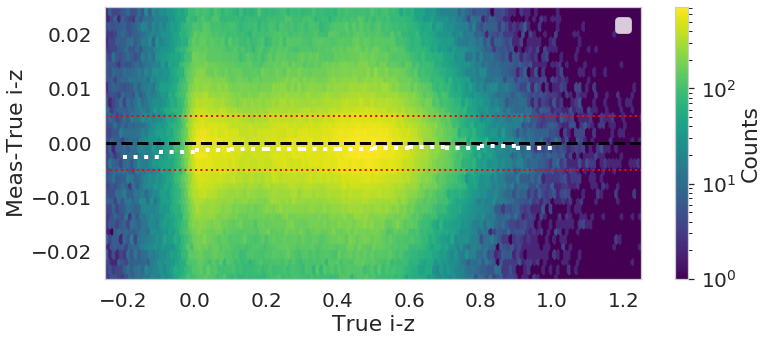

In [53]:
import matplotlib.colors as mcolors
plt.hexbin(x[c_cuts], y[c_cuts], gridsize=(300, 800), norm=mcolors.LogNorm(), cmap='viridis')
plt.colorbar(label='Counts')
plt.xlim(-0.25, 1.25)
plt.ylim(-0.025, .025)
plt.xlabel('True i-z')
plt.ylabel('Meas-True i-z')
plt.axhline(0, lw=3, c='k', ls='--')
med=np.median(y[c_cuts])
# plt.axhline(med, c='w', lw=2, ls=':', label=f'med={int(1000*med)} mmag')
plt.legend(fancybox=True, frameon=True)

mbins = np.arange(-0.2, 1.1, .1)
for b1, b2 in zip(mbins[:-1], mbins[1:]):
    in_bin = np.where(
        (x[c_cuts] > b1) &
        (x[c_cuts] <= b2)
    )
    ybin = y[c_cuts][in_bin]
    med = np.median(ybin)
    plt.plot([b1, b2], [med, med], lw=4, ls=':', c='w')
    
plt.axhline(-0.005, lw=2, ls=':', c='r')
plt.axhline(0.005, lw=2, ls=':', c='r')

plt.gcf().set_size_inches(12,5)

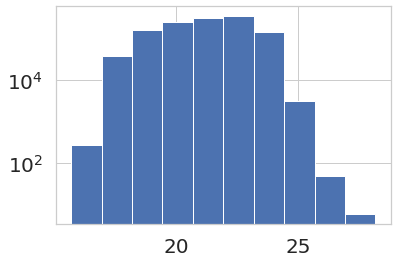

In [30]:
plt.hist(stars['meas_cm_mag_deredden'][:,2][stars['meas_cm_flux_s2n'][:,2]>0])
plt.yscale('log')

g 0
r 1
i 2
z 3


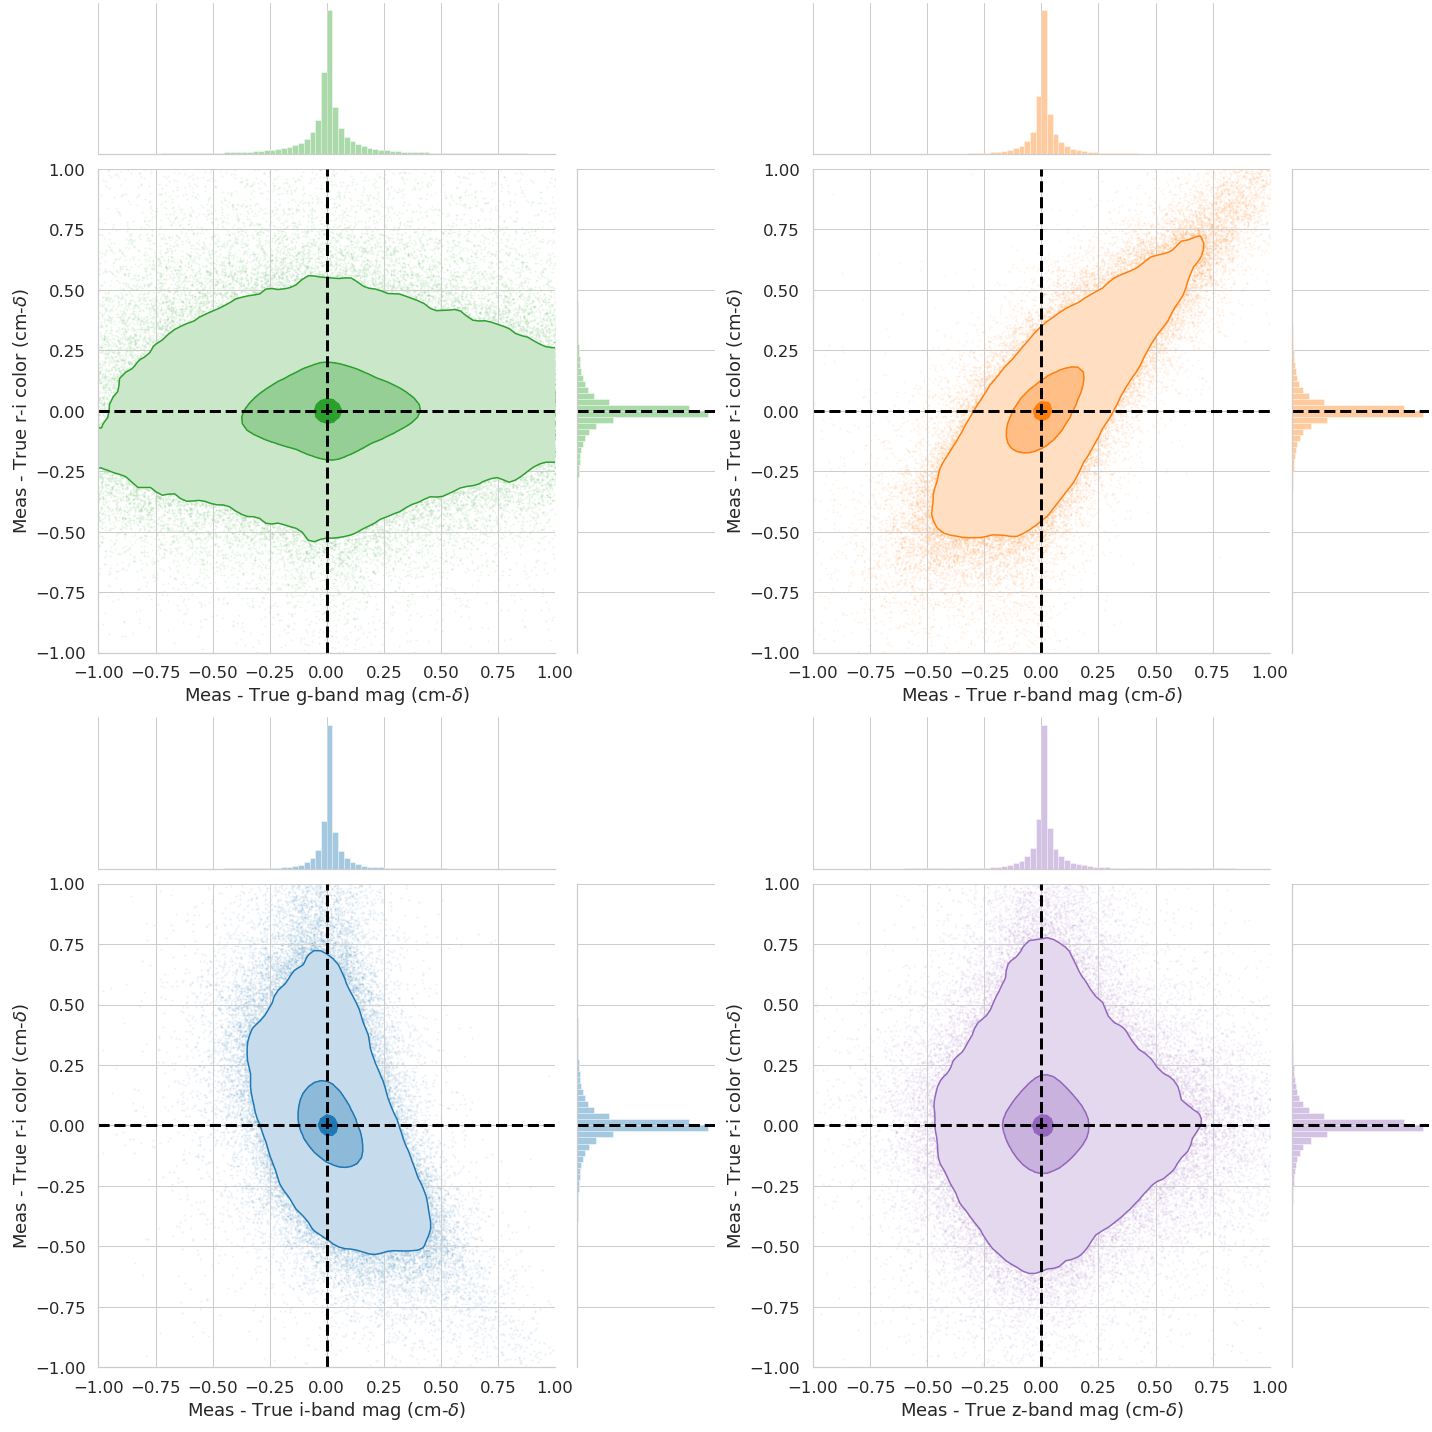

In [34]:
sb.set_style("whitegrid")# {"axes.facecolor": "0.9"})

bands = 'griz'
bindx = dict(zip('griz', range(4)))

xlim = [-1, 1]
ylim = [-1, 1]
r = (xlim, ylim)
bins = 75

dy = 0.025
ybins = np.arange(ylim[0], ylim[1]+dy, dy)

s = 20
N = 1
c = ['tab:green', 'tab:orange', 'tab:blue', 'tab:purple']
# c = ['limegreen', 'salmon', 'skyblue', 'orchid']

dl = 1.0
levels = 1.0 - np.exp(-0.5 * np.arange(dl, 3.+dl, dl) ** 2)

vb = True

# fig, axes = plt.subplots(2, 2)

g = {}

mag_suffix = '_deredden' # For corrected mags
# mag_suffix = '' # For uncorrected mags

stats_t = Table()

mags = []
mag_diff = []
colors = []
color_diff = []

b1, b2 = 'r', 'i'
b1i, b2i = 1, 2

r_i_true = stars[f'true_mag_{b1}'] - stars[f'true_mag_{b2}']
r_i_diff = stars['meas_cm_mag_deredden'][:, b1i] - stars['meas_cm_mag_deredden'][:, b2i] - r_i_true

k = 0
for b, bi in bindx.items():
    k += 1
#     if k >= 4:
#         break
    if vb is True:
        print(b, bi)
        
#     b1, b2 = 'griz'[bi], 'griz'[bi+1]
        
#     color = stars[f'true_mag_{b1}'] - stars[f'true_mag_{b2}'] 
#     color_diff = (stars['meas_cm_mag_deredden'][:, bi] - stars['meas_cm_mag_deredden'][:, bi+1]) - x

    x = stars[f'true_mag_{b}']
    y = stars[f'meas_cm_mag_deredden'][:,bi] - x

    cuts = np.where(
        (x > xlim[0]-1) &
        (x < xlim[1]+1) &
        (y > ylim[0]-1) &
        (y < ylim[1]+1)  )
    
    g[b] = sb.JointGrid(y, r_i_diff, ratio=3)    

    g[b].plot_joint(corner.hist2d, range=r, bins=75, scale_hist=1,
                    plot_datapoints=False, plot_density=True, no_fill_contours=False,
                    fill_contours=True,
                    color=c[bi], smooth=True, lw=3, alpha=0.01, levels=levels)
    plt.plot(y, r_i_diff, "o", ms=2, zorder=-1, rasterized=True, alpha=0.1, c=c[bi], mec='None')
    plt.axhline(0, ls='--', c='k', lw=3)
    plt.axvline(0, ls='--', c='k', lw=3)
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel(fr'Meas - True {b}-band mag (cm-$\delta$)')
    plt.ylabel(f'Meas - True r-i color (cm-$\delta$)')
    
    g[b].plot_marginals(sb.distplot, color=c[bi], bins=ybins, kde=False)
#     g[b].ax_marg_x._visible = False
#     g[b].ax_marg_y.hist(y[cuts][::N], color=c[bi], bins=ybins, orientation='horizontal')
    g[b].ax_marg_y.axhline(0, ls='--', c='k', lw=3)
    
fig = plt.figure(figsize=(s, s))
gs = gridspec.GridSpec(2, 2)

mg0 = SeabornFig2Grid(g['g'], fig, gs[0])
mg1 = SeabornFig2Grid(g['r'], fig, gs[1])
mg2 = SeabornFig2Grid(g['i'], fig, gs[2])
mg3 = SeabornFig2Grid(g['z'], fig, gs[3])

plt.tight_layout()
fig.set_size_inches(s, s)

In [41]:
sb.set_style("whitegrid")# {"axes.facecolor": "0.9"})

bands = 'griz'
bindx = dict(zip('griz', range(4)))

dy = 0.025
ybins = np.arange(ylim[0], ylim[1]+dy, dy)

s = 20
N = 1
c = ['tab:green', 'tab:orange', 'tab:blue', 'tab:purple']
# c = ['limegreen', 'salmon', 'skyblue', 'orchid']

dl = 1.0
levels = 1.0 - np.exp(-0.5 * np.arange(dl, 3.+dl, dl) ** 2)

vb = True

# fig, axes = plt.subplots(2, 2)

g = {}

mag_suffix = '_deredden' # For corrected mags
# mag_suffix = '' # For uncorrected mags

sample = -1 * np.ones((len(stars), 7))


# xlim = [-1, 1]
ylim = [-2, 2]

k = 0
for b, bi in bindx.items():
    k += 1
    if vb is True:
        print(b, bi)
        
    x = stars[f'true_mag_{b}']
    y = stars[f'meas_cm_mag_deredden'][:,bi] - x
    
#     cuts = np.where(
#         (y > ylim[0]-1) &
#         (y < ylim[1]+1)  )
    
    sample[:, k-1] = y
    
for b, bi in bindx.items():
    k += 1
    if k >= 8:
        break
        
    b1, b2 = 'griz'[bi], 'griz'[bi+1]
    if vb is True:
        print(f'{b1}-{b2}', bi)
        
    x = stars[f'true_mag_{b1}'] - stars[f'true_mag_{b2}'] 
    y = (stars['meas_cm_mag_deredden'][:, bi] - stars['meas_cm_mag_deredden'][:, bi+1]) - x
        
#     cuts = np.where(
#         (y > ylim[0]-1) &
#         (y < ylim[1]+1)  )
    
    sample[:, k-1] = y

g 0
r 1
i 2
z 3
g-r 0
r-i 1
i-z 2


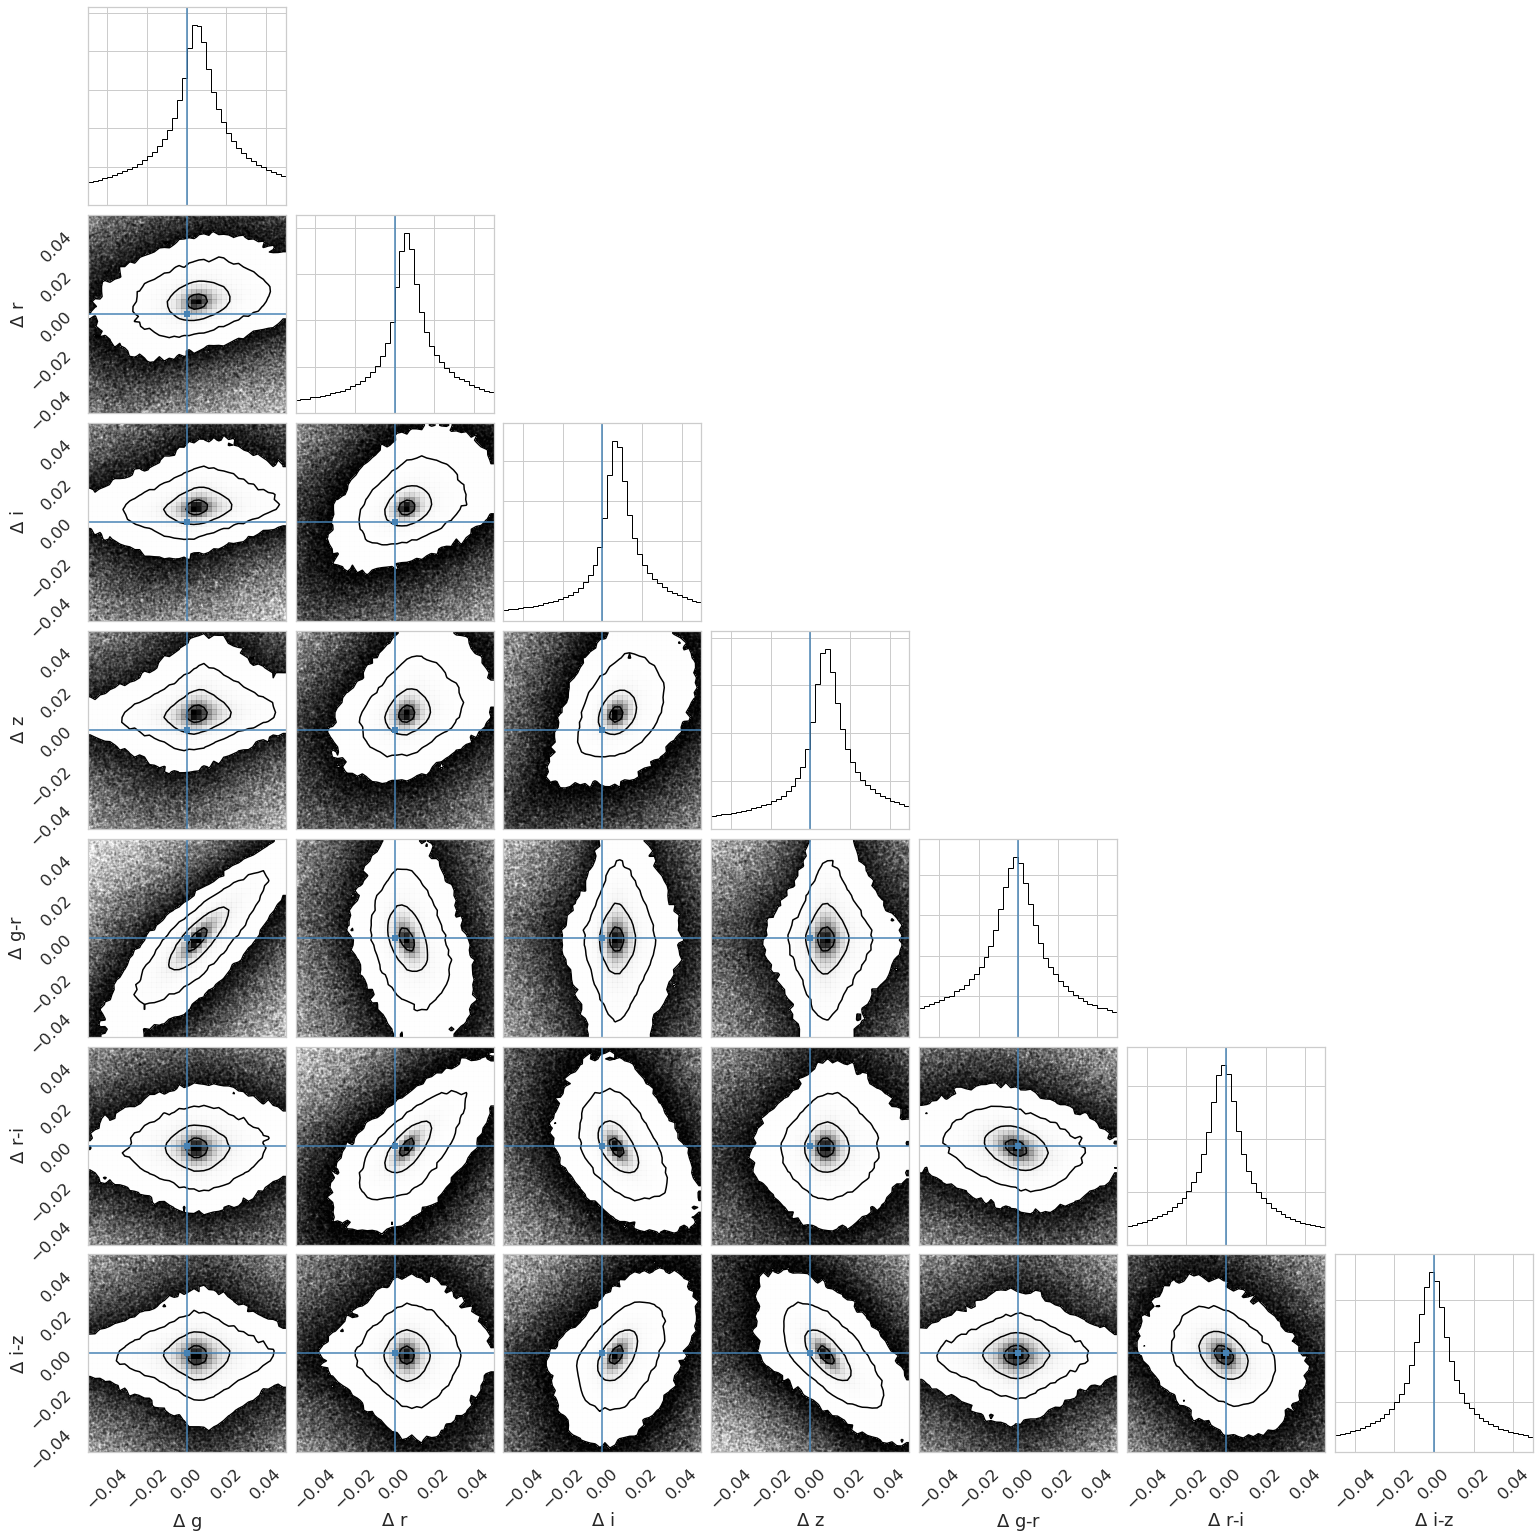

In [50]:
r = 7 * [(-.05, .05)]
labels = [
    r'$\Delta$ g',
    r'$\Delta$ r',
    r'$\Delta$ i',
    r'$\Delta$ z',
    r'$\Delta$ g-r',
    r'$\Delta$ r-i',
    r'$\Delta$ i-z',
]

dl = 1.0
levels = 1.0 - np.exp(-0.5 * np.arange(dl, 3.+dl, dl) ** 2)

corner.corner(sample, range=r, labels=labels, bins=40, truths=7*[0])#, levels=levels)
plt.gcf().set_size_inches(22, 22)

### Other responses:

g 0
r 1
i 2
z 3


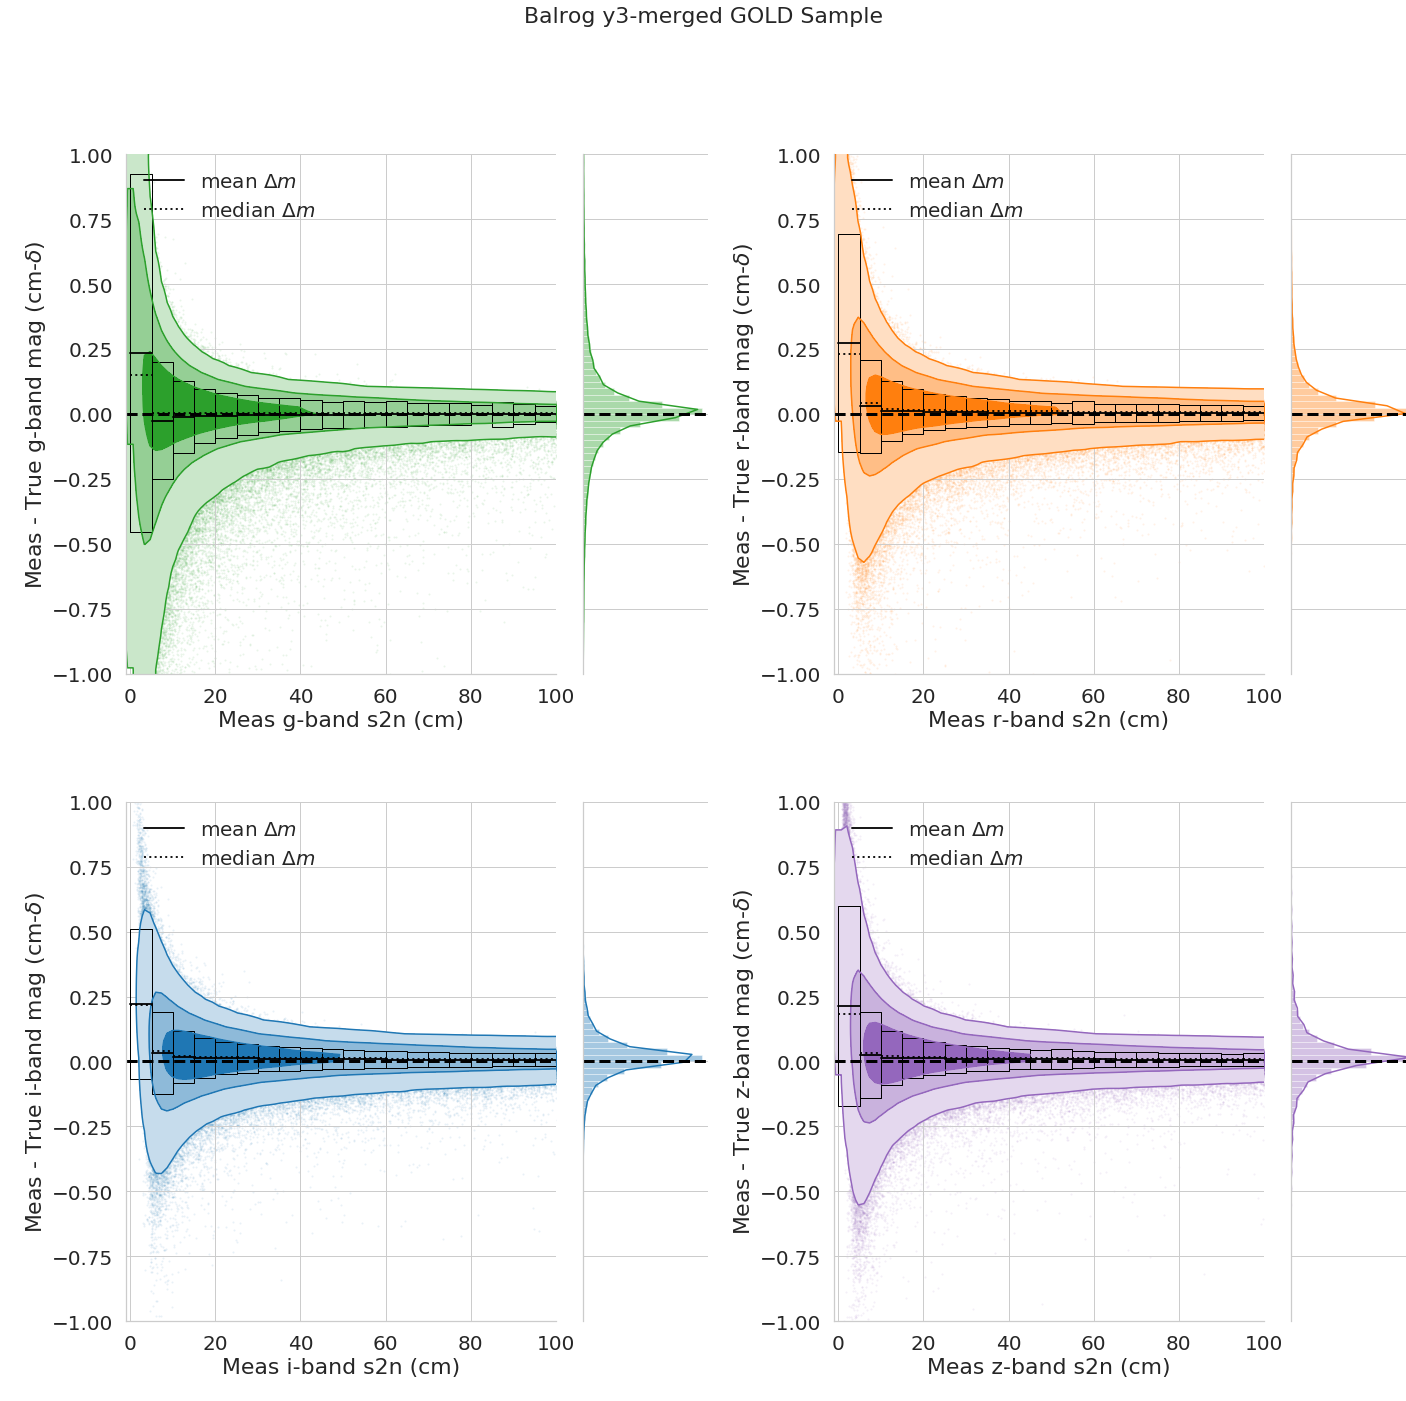

In [9]:
sb.set_style("whitegrid")# {"axes.facecolor": "0.9"})

bands = 'griz'
bindx = dict(zip('griz', range(4)))

xlim = [0, 100]
ylim = [-1, 1]
r = (xlim, ylim)
bins = 75

dy = 0.025
ybins = np.arange(ylim[0], ylim[1]+dy, dy)

s = 20
N = 1
c = ['tab:green', 'tab:orange', 'tab:blue', 'tab:purple']
# c = ['limegreen', 'salmon', 'skyblue', 'orchid']

dl = 1.0
levels = 1.0 - np.exp(-0.5 * np.arange(dl, 3.+dl, dl) ** 2)

vb = True

# fig, axes = plt.subplots(2, 2)

g = {}

mag_suffix = '_deredden' # For corrected mags
# mag_suffix = '' # For uncorrected mags

stats_t = Table()

k = 0
for b, bi in bindx.items():
    k += 1
    if vb is True:
        print(b, bi)
        
    x = stars['meas_cm_flux_s2n'][:, bi]
    y = stars[f'meas_cm_mag{mag_suffix}'][:, bi] - stars[f'true_mag_{b}']

    cuts = np.where(
        (x > xlim[0]-1) &
        (x < xlim[1]+1) &
        (y > ylim[0]-1) &
        (y < ylim[1]+1)  )

# ax1 = fig.add_subplot(1, 1, 1)
    g[b] = sb.JointGrid(x[cuts][::N], y[cuts][::N], ratio=3)    
#     plt.subplot(2, 2, k)  
#     corner.hist2d(x[cuts][::N], y[cuts][::N], range=r, bins=bins, color=c[bi])
#     g[b].plot_joint(plt.hexbin, gridsize=50, color=c[bi])
    g[b].plot_joint(corner.hist2d, range=r, bins=75, scale_hist=1,
                   plot_datapoints=False, plot_density=False, no_fill_contours=False,
                   fill_contours=True,
                   color=c[bi], smooth=True, lw=3, alpha=0.01, levels=levels)
    plt.plot(x[cuts][::N], y[cuts][::N], "o", ms=2, zorder=-1, rasterized=True, alpha=0.1, c=c[bi], mec='None')
#     plt.hist2d(x[cuts][::10*N], y[cuts][::10*N], range=r, bins=75, scale_hist=1,
#                    plot_datapoints=True, plot_density=False, no_fill_contours=True,
#                    plot_contours=False, color=c[bi])
    plt.axhline(0, ls='--', c='k', lw=3)
#     g = sb.JointGrid(x[cuts][::N], y[cuts][::N], ax=plt.gca())
#     g.plot_joint(plt.hexbin, gridsize=50)

    # Get rolling bias & scatter
    dx = 5
    xbins = np.arange(xlim[0], xlim[1]+dx, dx)
    mean, med, scatter, bin_mean = calc_bin_stats(x, y, xbins)
    
    k = 0
    for b1, b2 in zip(xbins, xbins[1:]):
        if k == 0:
            l1 = r'mean $\Delta m$'
            l2 = r'median $\Delta m$'
        else:
            l1 = None
            l2 = None
        plt.plot([b1, b2], [mean[k], mean[k]], c='k', label=l1, lw=2, alpha=0.9)
        plt.plot([b1, b2], [med[k], med[k]], c='k', ls=':', label=l2, lw=2, alpha=0.9)
#         plt.fill_between([b1, b2], mean[k]+scatter[k], mean[k]-scatter[k], facecolor='lightgrey', edgecolor='dimgrey', alpha=0.2)
        plt.fill_between([b1, b2], mean[k]+scatter[k], mean[k]-scatter[k], facecolor='None', edgecolor='k')
        k += 1
#     plt.step(xbins[:-1], mean, c='r', label=r'mean $\Delta m$')
#     plt.step(xbins[:-1], med, c='g', label=r'median $\Delta$ m$')
    plt.legend(loc='upper left')
    
    # Save to table
    stats_t[f'mean_{b}'] = mean
    stats_t[f'med_{b}'] = med
    stats_t[f'std_{b}'] = scatter
    stats_t[f'bin_mean_{b}'] = bin_mean

    plt.xlim(xlim - np.array([1, 0]))
    plt.ylim(ylim)
    plt.xlabel(f'Meas {b}-band s2n (cm)')
    plt.ylabel(fr'Meas - True {b}-band mag (cm-$\delta$)')
    
    g[b].plot_marginals(sb.distplot, color=c[bi], bins=ybins)
    g[b].ax_marg_x._visible = False
#     g[b].ax_marg_y.hist(y[cuts][::N], color=c[bi], bins=ybins, orientation='horizontal')
    g[b].ax_marg_y.axhline(0, ls='--', c='k', lw=3)

#     g[b].ax_marg_x.set_axis_off()
    
fig = plt.figure(figsize=(s, s))
gs = gridspec.GridSpec(2, 2)

mg0 = SeabornFig2Grid(g['g'], fig, gs[0])
mg1 = SeabornFig2Grid(g['r'], fig, gs[1])
mg2 = SeabornFig2Grid(g['i'], fig, gs[2])
mg3 = SeabornFig2Grid(g['z'], fig, gs[3])

# mg0.sg.ax_marg_x.remove()

plt.tight_layout()
fig.suptitle('Balrog y3-merged GOLD Sample')
fig.set_size_inches(s, s)

# Save table
if 'deredden' in mag_suffix:
    l = 'deredden'
else:
    l = 'uncorrected'
stats_t.write(f'./tables/stars-scatter-mag-stats-{l}-s2n.fits', overwrite=True)

g 1
r 2
i 3
z 4
meas_cm_T 5
meas_cm_fracdev 6
meas_cm_s2n_r 7
true_mag_i 8


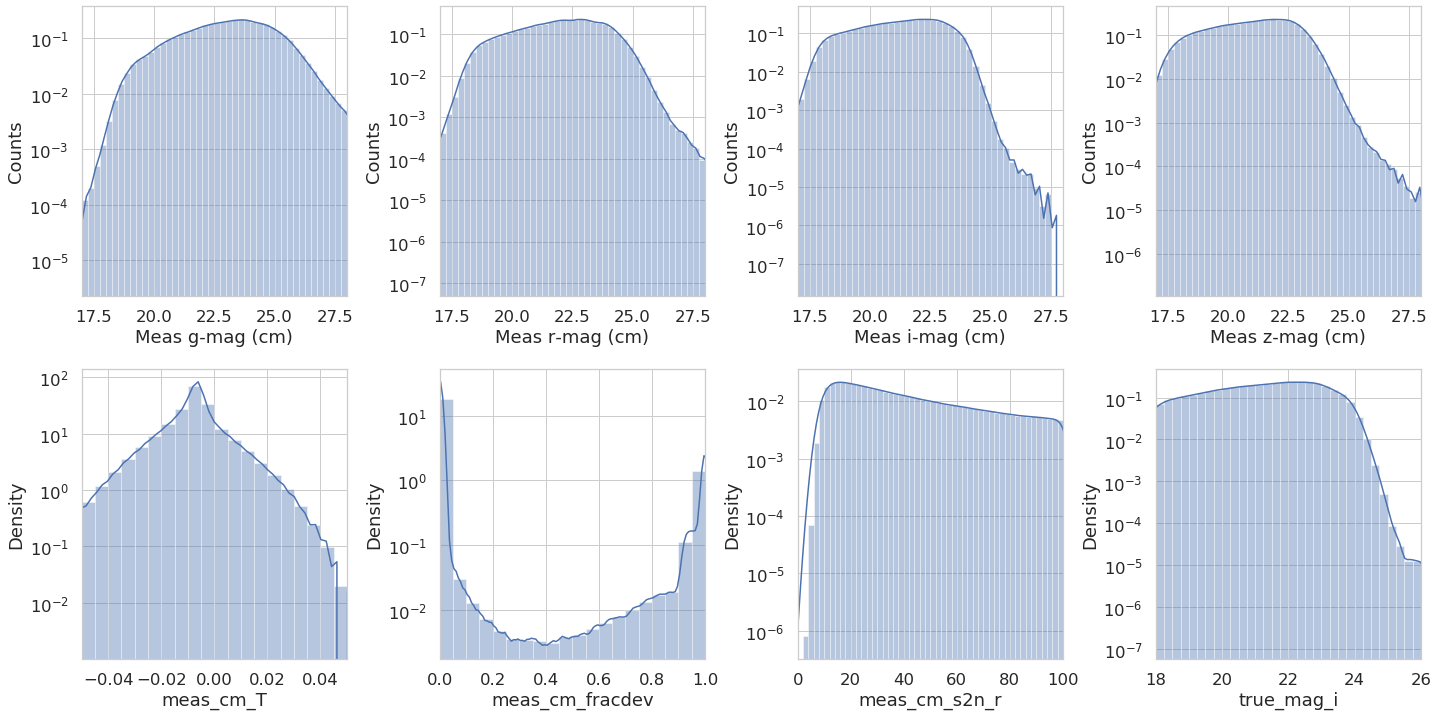

In [114]:
sb.set_style('whitegrid')

fig = plt.Figure()

vb = True

bindx = dict(zip('griz', range(4)))

xlim = {
    'meas_cm_mag_deredden' : [17, 28],
    'meas_cm_T' : [-.05, 0.05],
    'meas_cm_fracdev': [0, 1],
    'meas_cm_s2n_r' : [0, 100],
    'true_mag_i' : [18, 26]
}

dx = {
    'meas_cm_mag_deredden' : 0.25,
    'meas_cm_T' : .005,
    'meas_cm_fracdev' : 0.05,
    'meas_cm_s2n_r' : 2,
    'true_mag_i' : 0.25
}

Nrows, Ncols = 2, 4
gs = gridspec.GridSpec(Nrows, Ncols)

cols = ['meas_cm_T', 'meas_cm_fracdev', 'meas_cm_s2n_r', 'true_mag_i']

k = 0
for b in 'griz':
    k += 1
    
    bi = bindx[b]
    if vb is True:
        print(b, k)

    col = 'meas_cm_mag_deredden'
    
    x = stars[col][:,bi]
    
#     cuts = np.where(
#         (x > xlim[0]-1) &
#         (x < xlim[1]+1)
#     )
    
    plt.subplot(Nrows, Ncols, k)
    
    xbins = np.arange(xlim[col][0], xlim[col][1]+dx[col], dx[col])
    sb.distplot(x, bins=xbins, norm_hist=False)
    plt.xlabel(f'Meas {b}-mag (cm)')
    plt.ylabel('Counts')
    plt.xlim(xlim[col])
    plt.yscale('log')
    
for col in cols:
    k += 1
    
    if vb is True:
        print(col, k)
        
    x = stars[col]
    
    cuts = np.where(
        (x > xlim[col][0]-1) &
        (x < xlim[col][1]+1)
    )
        
    x = x[cuts]
    
    plt.subplot(Nrows, Ncols, k)
    
    if 'fracdev' in col:
        kws = {'bw' : 0.01}
    else:
        kws = None
    
    xbins = np.arange(xlim[col][0], xlim[col][1]+dx[col], dx[col])
    sb.distplot(x, bins=xbins, norm_hist=False, kde_kws=kws)
    plt.xlabel(f'{col}')
    plt.ylabel('Density')
    plt.xlim(xlim[col])
    plt.yscale('log')
    
w = 0.35
h = 0.25
plt.subplots_adjust(wspace=w, hspace=h)
plt.gcf().set_size_inches(24, 12)

(0, 1)

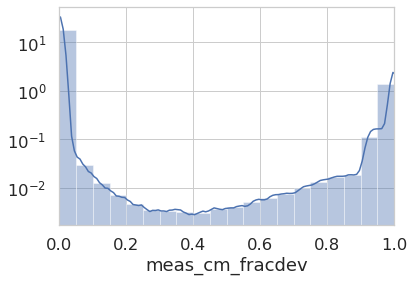

In [102]:
# plt.hist(stars['meas_cm_fracdev'], density=True)
sb.distplot(stars['meas_cm_fracdev'], bins=np.arange(0, 1+.05, .05), kde_kws={'bw':.01})
plt.yscale('log')
plt.xlim([0, 1])
# plt.ylim([1e-10, 1e1])

(0, 100)

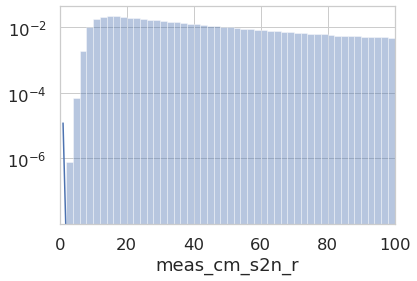

In [111]:
sb.distplot(stars['meas_cm_s2n_r'], bins=np.arange(0, 100+2, 2), kde_kws={'bw':1})
plt.yscale('log')
plt.xlim(0, 100)